# Chapter05 순환 신경망(RNN)

지금까지 살펴본 신경망은 $\textbf{피드 포워드}^{\text{feed forward, 앞먹임}}$ 유형의 신경망이다.

피드 포워드란 흐름이 단방향인 신경망으로, 입력 신호가 한 방향으로만 전달되는 신경망을 말한다.

피드 포워드 신경망은 구성이 단순하여 구조 이해가 쉽고 많은 문제에 응용가능하나,

시계열 데이터를 잘 다루지 못한다는 단점이 있다.

더 정확히는, 단순한 피드 포워드 신경망에서는 시계열 데이터의 성질(패턴)을 충분히 할 수 없다.

그래서 $\textbf{순환 신경망}^{\text{Recurrent Neural Network}} \textbf{(RNN)}$ 이 등장하게 된다.

## 5.1 확률과 언어 모델

앞 장의 word2vec을 복습하면서 자연어에 관한 현상을 '확률'을 통해 기술하고, 마지막에는 언어를 확률로 다루는 '언어 모델'에 대해 설명한다.

### 5.1.1 word2vec을 확률 관점에서 바라보다

word2vec의 CBOW 모델부터 복습해본다. 이때 $w_1, w_2, \cdots, w_T$ 라는 단어열로 표현되는 말뭉치를 가정한다.

그리고 $t$ 번째 단어를 '타깃'으로, 전후 단어($t-1$ 번째, $t+1$ 번째)를 '맥락'으로 취급한다.

이때 CBOW 모델은 [그림 5-1]과 같이 맥락 $w_{t-1}$ 과 $w_{t+1}$ 을 추측하는 일을 수행한다.

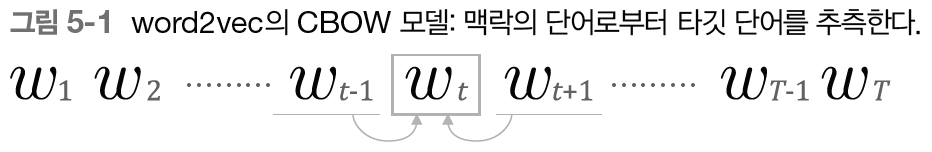

In [1]:
import os
from PIL import Image

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
img_path = os.path.join(parent_dir, 'images')

Image.open(os.path.join(img_path, 'fig 5-1.png'))

이때 $w_{t-1}$ 과 $w_{t+1}$ 이 주어졌을 때 타깃이 $w_t$가 될 확률을 수식으로 나타내면 다음과 같다.

\begin{equation*}
    P(w_t | w_{t-1}, w_{t+1})
    \tag{5.1}
\end{equation*}

CBOW 모델은 식 (5.1)의 사후 확률을 모델링한다. 이 사후 확률은 '$w_{t-1}$ 과 $w_{t+1}$ 이 주어졌을 때 $w_t$ 가 일어날 확률'을 뜻한다. 이것은 윈도우 크기가 1일 때의 CBOW 모델이다.

지금까지는 맥락을 항상 좌우 대칭으로 생각해왔는데, 이번에는 맥락을 왼쪽 윈도우에 한정해본다.

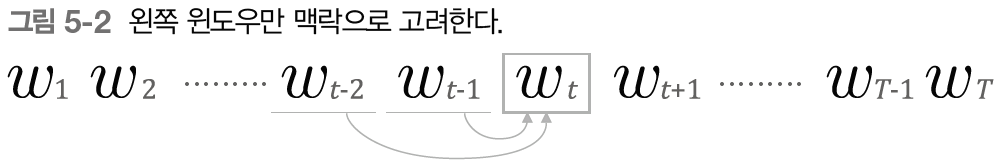

In [2]:
Image.open(os.path.join(img_path, 'fig 5-2.png'))

그러면 CBOW 모델이 출력할 확률은 다음 식과 같게 된다.

\begin{equation*}
    P(w_t | w_{t-1}, w_{t-2})
    \tag{5.2}
\end{equation*}

이 경우 CBOW 모델이 다루는 손실 함수는 교차 엔트로피 오차에 의해 다음과 같이 유도된다.

\begin{equation*}
    L = -\log P(w_t | w_{t-1}, w_{t-2})
    \tag{5.3}
\end{equation*}

CBOW 모델의 학습으로 수행하는 일은 식 (5.3)의 손실 함수(말뭉치 전체의 손실 함수의 총합)를 최소화하는 가중치 매개변수를 찾는 것이다.

이러한 가중치 매개변수가 발견되면 CBOW 모델은 맥락으로부터 타깃을 더 정확하게 추측할 수 있게 된다.

이처럼 CBOW 모델을 학습시키는 본래 목적은 맥락으로부터 타깃을 정확하게 추측하는 것이다.

이 목적을 위해 학습을 진행하면, 단어의 의미가 인코딩된 '단어의 분산 표현'을 얻을 수 있다.

그럼 자연스레 CBOW 모델의 본래 목적인 '맥락으로부터 타깃을 추측하는 것'을 좀 더 폭넓게 쓰고 싶은 욕심이 생기게 된다.

달리 말해 식 (5.2)의 확률을 실용적으로 쓰고 싶은 생각이 드는데, 여기서 '언어 모델'이 등장한다.

### 5.1.2 언어 모델

$\textbf{언어 모델}^{\text{Language Model}}$ 은 단어 나열에 확률을 부여한다.

특정한 단어의 시퀀스에 대해서, 그 시퀀스가 일어날 가능성을 확률로 평가한다(얼마나 자연스러운 단어 순서인지).

이 언어 모델은 다양하게 응용 가능하다.
- 기계 번역 : 외국어 문장 자동 한국어 번역
- 음성 인식 : 사람 음성으로부터 몇 개의 문장 후보 생성 $\rightarrow$ 언어 모델 $\rightarrow$ 자연스러운 순서로 문장 배열
- 문장 생성 : 단어 순서의 자연스러움에 대한 확률적 평가 가능 $\rightarrow$ 확률분포에 따라 다음으로 적합한 단어 샘플링

언어 모델 수식
- $w_1, \ldots, w_m$ : $m$ 개 단어로 된 문장
- $P(w_1, \ldots, w_m)$ : 단어가 $w_1, \ldots, w_m$ 이라는 순서로 출현할 확률 (결합확률, 동시확률)

\begin{align*}
    P(w_1, \ldots, w_m) & = P(w_m | w_1, \ldots, w_{m-1}) P(w_{m-1} | w_1, \ldots, w_{m-2}) \\
    & \quad \cdots P(w_3 | w_1, w_2) P(w_2 | w_1) P(w_1) \\
    & = \prod_{t=1}^{m} P(w_t | w_1, \ldots w_{t-1})
    \tag{5.4}
\end{align*}

식 (5.4) 에서 알 수 있듯이 목적으로 하는 동시 확률 $P(w_1, \ldots, w_m)$ 은 사후확률의 총곱인 $\prod_{t=1}^{m} P(w_t | w_1, \ldots w_{t-1})$ 으로 대표될 수 있다. 

여기서 주목해야 할 점은 이 사후 확률은 타깃 단어보다 왼쪽에 있는 모든 단어를 맥락(조건)으로 했을 때의 확률이라는 것이다.

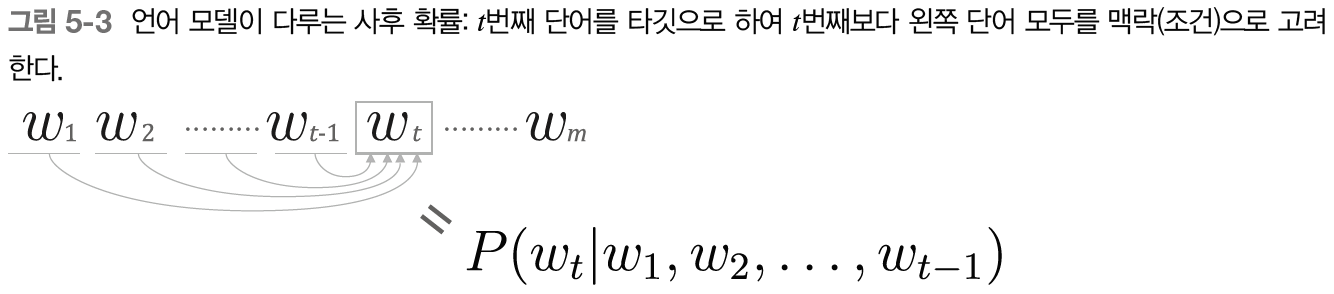

In [3]:
Image.open(os.path.join(img_path, 'fig 5-3.png'))

정리하면, 우리의 목표는 $P(w_t | w_1, \ldots, w_{t-1})$ 이라는 확률을 얻는 것이다.

이 확률에 대한 계산이 가능하게 되면 언어 모델의 동시 확률 $P(w_1, \ldots, w_m)$ 을 구할 수 있게 된다.

$\textbf{NOTE}$

$P(w_t | w_1, \ldots, w_{t-1})$ 을 나타내는 모델은 $\textbf{조건부 언어 모델}^{\text{Conditional Language Model}}$ 이라고 한다. 한편, $P(w_t | w_1, \ldots, w_{t-1})$ 을 나타내는 모델을 가리켜, 그것을 '언어 모델'이라 하는 경우도 많이 볼 수 있다.

### 5.1.3 CBOW 모델을 언어 모델로?

그러면 word2vec의 CBOW 모델을 (억지로) 언어 모델에 적용하려면 어떻게 하면 좋을까?

맥락의 크기를 특정 값으로 한정해서 근사적으로 나타내 볼 수 있다. 수식으로는 다음과 같다.

\begin{equation*}
    P(w_1, \ldots, w_m) = \prod_{t=1}^{m} P(w_t | w_1, \ldots, w_{t-1}) \approx \prod_{t=1}^{m} P(w_t | w_{t-1}, w_{t-2})
    \tag{5.5}
\end{equation*}

식 (5.5)는 맥락을 왼쪽 2개의 단어로 한정한 경우이다. 

그러면 CBOW 모델에 따라 (CBOW 모델의 사후 확률에 따라) 언어 모델의 동시확률을 근사적으로 나타낼 수 있게 된다.

$\textbf{NOTE}$

머신러닝이나 통계학에서는 $\textbf{마르코프 연쇄}^{\text{Markov Chain}}$ 또는 $\textbf{마르코프 모델}^{\text{Markov Model}}$ 이라는 말을 자주 듣는다. 마르코프 연쇄란 미래의 상태가 현재 상태에만 의존해 결정되는 것을 말한다. 또한 이 사상의 확률이 '그 직전' $N$ 개의 사건에만 의존할 때, 이를 '$N$ 층 마르코프 연쇄' 라고 한다. 식 (5.5)의 경우 직전 2개의 단어에만 의존해 다음 단어가 정해지는 모델을 고려하므로 '2층 마르코프 연쇄'라고 부를 수 있다.

식 (5.5) 에서는 맥락으로 2개의 단어를 이용하는 예를 나타냈으나, 맥락의 크기는 임의 길이로 설정 가능하다(5개, 10개 등).

그러나 임의 길이로 설정할 수 있다고 해도, 결국 특정 길이로 '고정'된다.

예를 들어 왼쪽 10개의 단어를 맥락으로 CBOW 모델을 만들 때, 그 맥락보다 더 왼쪽에 있는 단어의 정보는 무시된다.

예를 들면 다음 그림과 같다.

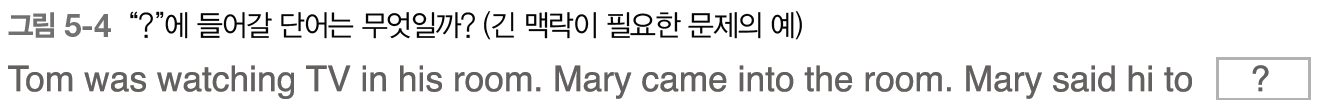

In [4]:
Image.open(os.path.join(img_path, 'fig 5-4.png'))

[그림 5-4]의 문제의 정답은 문맥(맥락)을 고려하면 'Tom'이 된다.

즉 언어 모델이 이 문제를 풀려면 예문의 "?"로부터 18번째 앞에 있는 "Tom"을 기억해야 한다.

CBOW 모델의 경우 고정된 맥락크기가 10인 경우 (혹은 18개 미만) 이 문제에 제대로 대답할 수 없다.

그럼 CBOW 모델의 맥락 크기를 늘리면 문제가 해결 될 것인가? 크기는 무한정 늘릴 순 있다.

그러나 CBOW 모델에서는 맥락 안의 단어 순서가 무시된다는 한계가 존재한다.

맥락의 단어 순서가 무시되는 문제의 구체적인 예를 보도록 한다.

예를 들어 맥락으로 2개의 단어를 다루는 경우, CBOW 모델에서는 다음 그림과 같이 이 2개의 단어 벡터의 '합'이 은닉층에 온다.

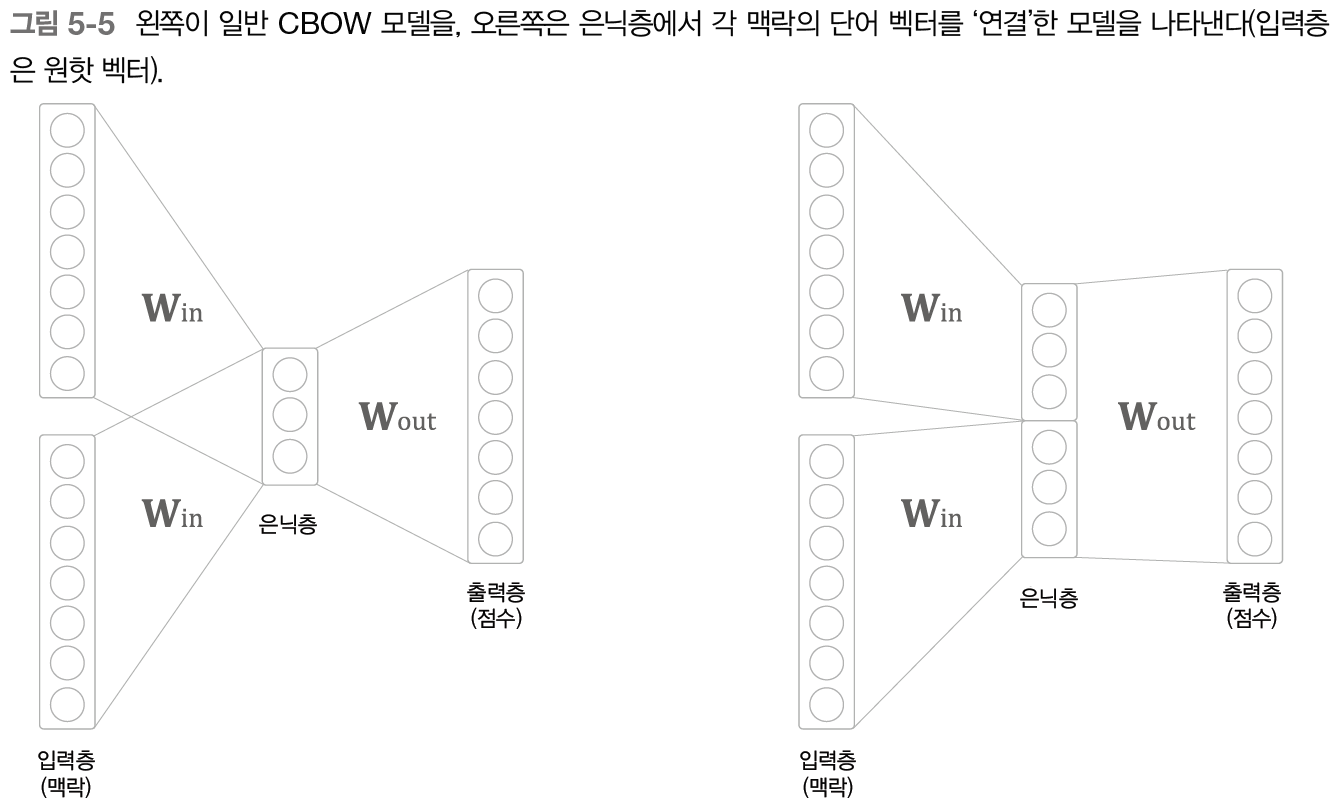

In [5]:
Image.open(os.path.join(img_path, 'fig 5-5.png'))

[그림 5-5]의 왼쪽 그림과 같이 CBOW 모델의 은닉층에서는 단어 벡터들이 더해지므로 맥락의 단어 순서는 무시된다. 예를 들어 (you, say)와 (say, you)라는 맥락은 동일한 맥락으로 취급된다.

이상적으로는 맥락의 단어 순서도 고려한 모델이 바람직할 것이다.

이를 위해 [그림 5-5]의 오른쪽 그림처럼 맥락의 단어 벡터를 은닉층에서 $\textbf{연결}^{\text{concatenate}}$ 하는 방식을 생각할 수 있다. 실제로 $\text{신경 확률론적 언어 모델}^{\text{Neural Probabilistic Language Model}}$ 에서 제안하는 모델은 이 방식을 채택한다. 

그러나 이러한 연결 방식은 맥락의 크기에 비례해서 가중치 매개변수도 늘어난다는 단점이 있다.

그렇다면 이 문제는 어떻게 해결해야 할 것인가? 여기서 등장하는 것이 순환 신경망, 즉 RNN이다.

RNN은 맥락이 아무리 길더라도 그 맥락의 정보를 기억하는 메커니즘을 갖춘다. 그래서 RNN을 사용하면 아무리 긴 시계열 데이터여도 대응가능하다.

$\textbf{WARNING}$

word2vec은 애초의 목적이 단어의 분산 표현을 얻기 위함을 잊지 말도록 한다.

## 5.2 RNN 이란

$\textbf{RNN}^{\text{Recurrent Neural Network}}$ 의 'Recurrent'는 라틴어에서 온 말로, '몇 번이나 반복해서 일어나는 일'을 뜻한다. 우리말로 '재발한다', '주기적으로 일어난다', '순환한다'등으로 번역된다. 그래서 RNN을 직역하면 '순환하는 신경망'이 되는 것이다. 이제부터 이 '순환한다'는 말의 의미를 이해해보도록 한다.

$\textbf{WARNING}$

Recurrent Neural Network는 우리말로 '순환 신경망'으로 번역된다. 한편, Recursive Neural Network(재귀 신경망)라는 신경망도 있다. 이는 주로 트리 구조의 데이터를 처리하기 위한 신경망으로, 순환 신경망과는 다른 것이다.

### 5.2.1 순환하는 신경망

- '순환' : 어느 한 지점에서 시작해서 시간을 지나 다시 원래 장소로 돌아오는 것을 '반복'하는 과정. 순환을 위해선 '닫힌 경로'가 필요함.

RNN의 특징은 순환하는 경로(닫힌 경로)가 있다는 것이다.

이 순환 경로를 따라 데이터는 끊임없이 순환하고 이를 통해 과거의 정보를 기억하는 동시에 최신 데이터로 갱신가능하다.

RNN을 구체적으로 살펴보도록 한다. RNN에 이용되는 계층을 'RNN 계층'이라고 부르도록 한다.

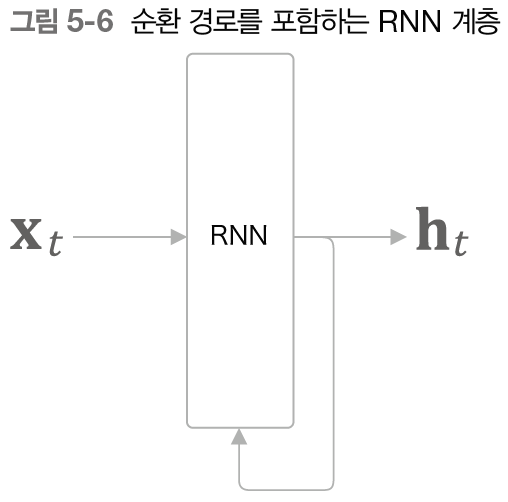

In [6]:
Image.open(os.path.join(img_path, 'fig 5-6.png'))

[그림 5-6]처럼 RNN 계층은 순환하는 경로를 포함한다. 이 순환 경로를 따라 데이터를 계층 안에서 순환시킬 수 있다.

또한 $\mathbf{x}_{t}$ 를 입력받는데, $t$ 는 시각을 뜻한다.

이는 시계열 데이터 $(\mathbf{x}_{0}, \mathbf{x}_{1}, \ldots, \mathbf{x}_{t}, \ldots)$ 가 RNN 계층에 입력됨을 표현한 것이다.

이러한 입력값에 대하여 $(\mathbf{h}_{0}, \mathbf{h}_{1}, \ldots, \mathbf{h}_{t}, \ldots)$ 가 출력된다.

또한 각 시각에 입력되는 $\mathbf{x}_{t}$ 는 벡터라고 가정한다. 문장(단어 순서)을 다루는 경우를 예로 든다면 각 단어의 분산 표현(단어 벡터)이
$\mathbf{x}_{t}$ 가 되며, 이 분산 표현이 순서대로 하나씩 RNN 계층에 입력되는 것이다.

$\textbf{WARNING}$

[그림 5-6]을 자세히 보면 출력이 2개로 분기하고 있음을 알 수 있다. 여기서 말하는 '분기'란 같은 것이 복제되어 분기함을 의미한다. 그리고 이렇게 분기된 출력 중 하나가 자기 자신에 입력된다(즉, 순환한다).

그리고 지면관계상, 지금부터는 데이터가 아래에서 위로 흐르도록 그리고자 한다(순환 구조를 펼칠 때, 계층을 양옆으로 펼치기 위해서 이렇게 그리는 것).

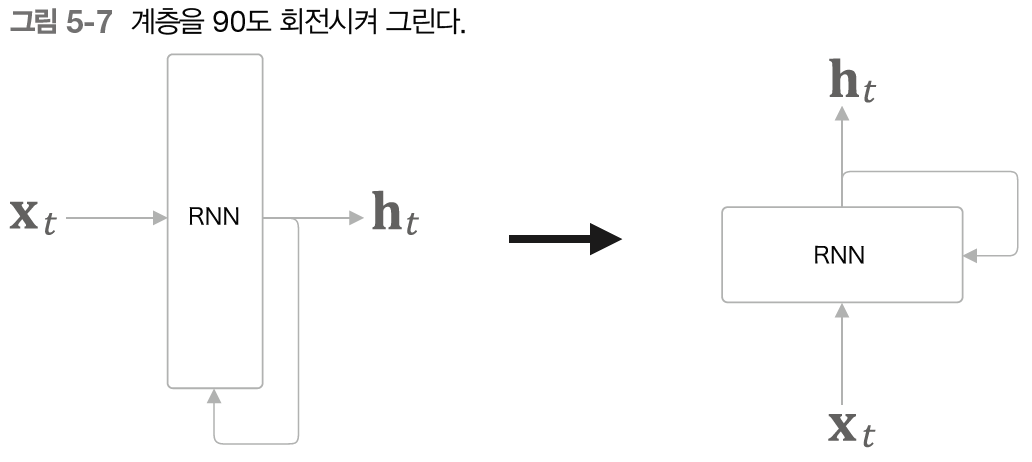

In [7]:
Image.open(os.path.join(img_path, 'fig 5-7.png'))

### 5.2.2 순환 구조 펼치기

이것으로 준비는 다 되었다. 이제 RNN 계층의 순환 구조에 대해 자세히 살펴보도록 한다.

RNN의 순환 구조는 지금까지의 신경망에는 존재하지 않던 구조이다. 그러나 이 순환 구조를 펼치면 친숙한 신경망으로 '변신'시킬 수 있다.

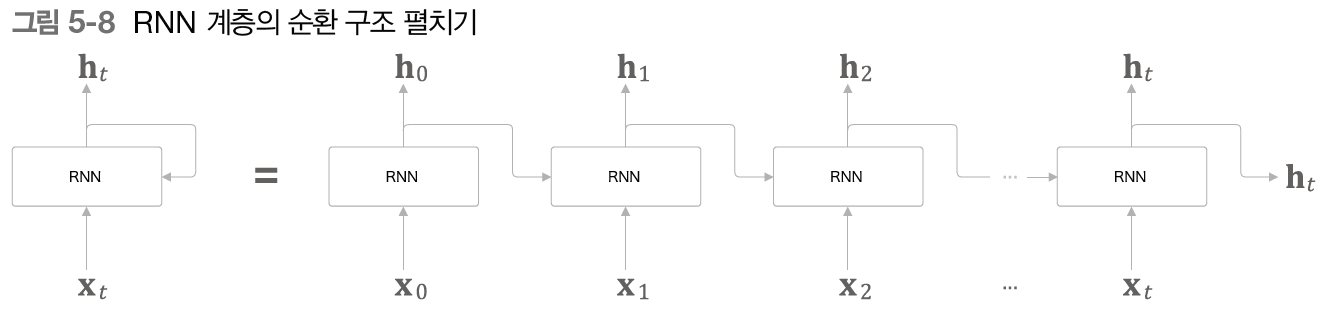

In [8]:
Image.open(os.path.join(img_path, 'fig 5-8.png'))

[그림 5-8]과 같이, RNN 계층의 순환 구조를 펼침으로써 오른쪽으로 성장하는 긴 신경망으로 변신시킬 수 있다.

지금까지 본 피드포워드 신경망과 같은 구조(피드포워드에서는 데이터가 한 방향으로만 흐른다)이다.

다만, [그림5-8]에 등장하는 다수의 RNN 계층 모두가 실제로는 '같은 계층'인 것이 지금까지의 신경망과는 다르다.

$\textbf{WARNING}$

시계열 데이터는 시간 방향으로 데이터가 나열된다. 따라서 시계열 데이터의 인덱스를 가리킬 때는 '시각'이라는 용어를 사용한다(예컨대 시각 $t$ 의 입력 데이터 $\mathbf{x}_{t}$ 등). 자연어의 경우에도 '$t$ 번째 단어'나 '$t$ 번째 RNN 계층'이라는 표현도 사용하지만, '시각 $t$ 의 단어'나 '시각 $t$ 의 RNN 계층'처럼 표현하기도 한다.

[그림 5-8]과 같이, 각 시각의 RNN 계층은 그 계층으로의 입력과 1개 전의 RNN 계층으로부터의 출력을 받는다. 그리고 이 두 정보를 바탕으로 현 시각의 출력을 계산한다. 이때 수행하는 계산의 수식은 다음과 같다.

\begin{equation*}
    \mathbf{h}_{t} = \tanh (\mathbf{h}_t \mathbf{W}_{\mathbf{h}} + \mathbf{x}_t \mathbf{W}_{\mathbf{x}} + \mathbf{b}), \quad t \geq 1
    \tag{5.6}
\end{equation*}

- $\mathbf{W}_{\mathbf{x}}$ : 입력 $\mathbf{x}$ 를 출력 $\mathbf{h}$ 로 변환하기 위한 가중치
- $\mathbf{W}_{\mathbf{h}}$ : 시각 $t-1$ 의 RNN 계층 출력 $\mathbf{h}_{t-1}$ 을 다음 시각으로의 출력 $\mathbf{h}_{t}$ 로 변환하기 위한 가중치 $\mathbf{W}_{\mathbf{h}}$

(참고 : $\mathbf{h}_{t-1}$ 과 $\mathbf{x}_t$ 는 행벡터)

식 (5.6)에서는 행렬 곱을 계산하고, 그 합을 tanh 함수($\text{쌍곡탄젠트}^{\text{hyperbolic tangent}}$ 함수)를 이용해 변환한다.

그 결과가 시각 $t$ 의 출력 $\mathbf{h}_{t}$ 가 된다.

이러한 $\mathbf{h}_{t}$ 는 다른 계층을 향해 위쪽으로 출력됨과 동시에, 다음 시각의 RNN 계층(자기 자신)을 향해 오른쪽으로도 출력된다.

그런데 식 (5.6)을 보면 현재의 출력 ($\mathbf{h}_{t}$) 은 한 시각 이전 출력 ($\mathbf{h}_{t-1}$)에 기초해서 계산됨을 알 수 있다.

다른 관점으로 보면, RNN은 $\mathbf{h}$ 라는 '상태'를 가지고 있으며, 식 (5.6)의 형태로 갱신된다고 해석할 수 있을 것이다.

그래서 RNN 계층을 '상태를 가지는 계층'혹은 '메모리(기억력)가 있는 계층'이라고도 한다.

$\textbf{NOTE}$

RNN의 $\mathbf{h}$ 는 '상태'를 기억해서 시각이 1 스텝(1 단위) 진행될 때마다 식 (5.6)의 형태로 갱신된다. 많은 문헌에서 RNN의 출력 $\mathbf{h}_t$ 를 $\textbf{은닉 상태}^{\text{hidden state}}$ 혹은 $\textbf{은닉 상태 벡터}^{\text{hidden state vector}}$ 라고 한다. 이 책에서도 마찬가지로 RNN의 출력 $\mathbf{h}_t$ 를 '은닉 상태' 혹은 '은닉 상태 벡터'라고 부르기로 한다.

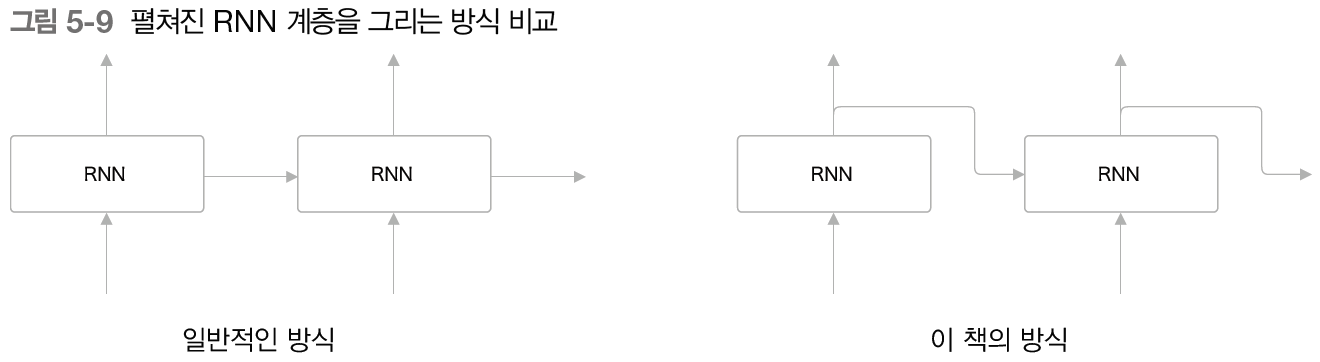

In [9]:
Image.open(os.path.join(img_path, 'fig 5-9.png'))

많은 문헌에서는 [그림 5-9]의 왼쪽과 같이 펼쳐진 RNN 계층을 그리는데, 이 책에서는 오른쪽 방식과 같이 데이터가 복사되는, 하나의 출력이 분기하는 것임을 명시하도록 한다.

### 5.2.3 BPTT

앞에서 봤듯 RNN 계층은 가로로 펼쳐진 신경망으로 간주할 수 있다. 따라서 RNN의 학습도 보통의 신경망과 같은 순서로 진행할 수 있다.

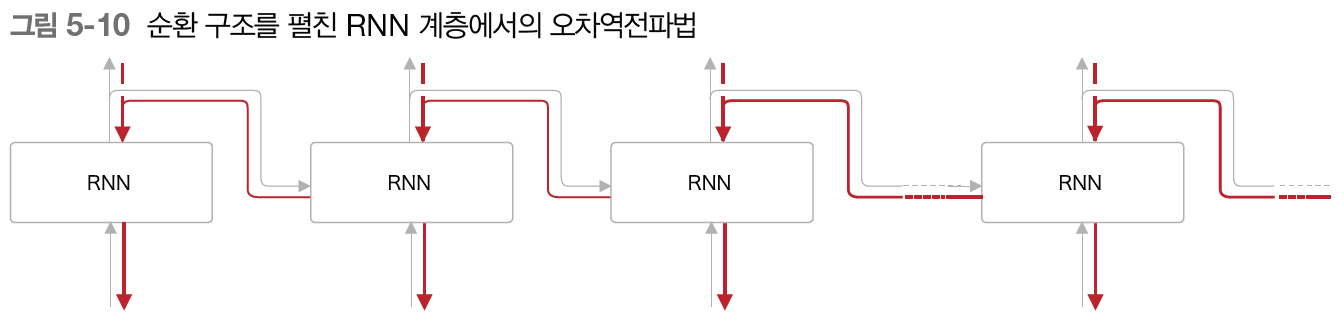

In [10]:
Image.open(os.path.join(img_path, 'fig 5-10.png'))

[그림 5-10]과 같이 순환 구조를 펼친 후의 RNN에는 (일반적인) 오차역전파법을 적용할 수 있다.

여기서의 오차역전파법은 '시간 방향으로 펼친 신경망의 오차역전파법'이란 뜻으로 $\textbf{BPTT}^{\text{Backpropagtion Through Time}}$ 라고 한다.

이러한 BPTT를 이용하면 RNN을 학습할 수 있을 듯 보이나, 그전에 해결해야 할 문제가 있다.

그것은 바로 긴 시계열 데이터를 학습할 때의 문제이다.

시계열 데이터의 시간 크기가 커지는 것에 비례해서 BPTT가 소비하는 컴퓨팅 자원도 증가하는 현상이 발생하며,

시간 크기가 커지면 역전파 시의 기울기가 불안정해지는 문제도 있다.

$\textbf{NOTE}$

BPTT를 이용해 기울기를 구하려면, 매 시각 RNN 계층의 중간 데이터를 메모리에 유지해두지 않으면 안된다. 따라서 시계열 데이터가 길어짐에 따라 계산량 뿐만 아니라 메모리 사용량도 증가하게 된다.

### 5.2.4 Truncated BPTT

큰 시계열 데이터를 취급할 때는 흔히 신경망 연결을 적당한 길이로 '끊는다'.

시간축 방향으로 너무 길어진 신경망을 적당한 지점에서 잘라내어 작은 신경망 여러 개로 만든다는 아이디어이다.

그리고 이 잘라낸 작은 신경망에서 오차역전파법을 수행한다. 이것이 바로 $\textbf{Truncated BPTT}$ 라는 기법이다.

Truncated BPTT에서는 신경망의 연결을 끊지만, 제대로 구현하려면 '역전파'의 연결만 끊어야 한다.

순전파의 연결은 반드시 그대로 유지해야 한다. 즉, 순전파의 흐름은 끊어지지 않고 전파된다.

한편, 역전파의 연결은 적당한 길이로 잘라내서 그 잘라낸 신경망의 단위로 학습을 수행한다.

- Truncated BPTT 예시

1. 길이가 1,000인 시계열 데이터 가정 (자연어 문제의 경우 단어 1,000개짜리 말뭉치), 여러 문장을 연결한 것을 하나의 시계열 데이터 취급
2. BPTT 그대로를 사용할 경우 펼쳐지는 RNN 계층이 1,000개가 되기 때문에 계산량과 메모리 사용량 크게 증가 & 계층이 길어짐에 따라 신경망을 하나 통과할 때마다 기울기 값이 조금씩 작아지면서 0으로 소멸하는 기울기 소실 문제 (vanishing gradient) 발생
3. 그러므로 가로로 길게 뻗은 신경망의 역전파 연결을 적당한 길이로 끊는다 ([그림 5-11])

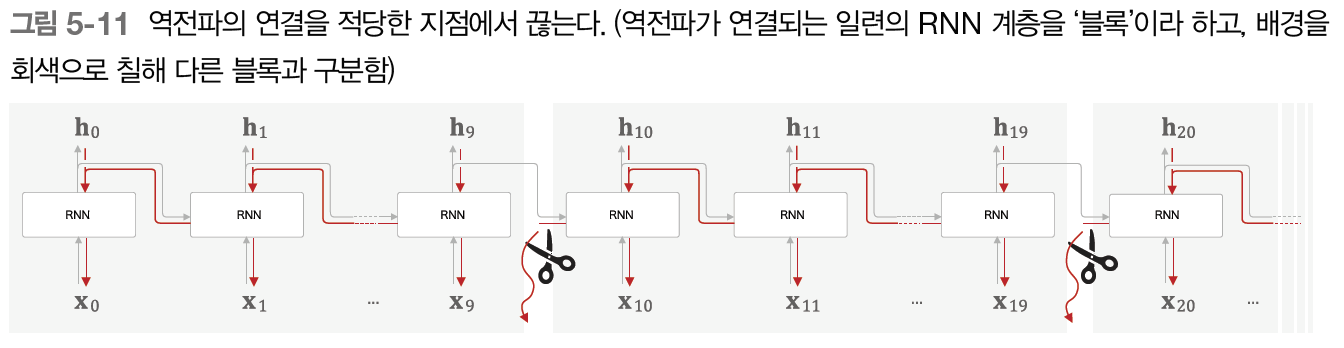

In [11]:
Image.open(os.path.join(img_path, 'fig 5-11.png'))

4. [그림 5-11]에서는 RNN 계층을 10개 단위로 학습할 수 있도록 역전파의 연결을 끊는다.

이렇게 역전파의 연결을 자르면, 그보다 미래의 데이터에 대해서는 생각할 필요가 없어지게 된다.

따라서 각각의 블록 단위로, 미래의 블록과는 독립적으로 오차역전파법을 완성시킬 수 있다.

여기서 반드시 기억해야 할 점은 역전파의 연결은 끊어지지만, 순전파의 연결은 끊어지지 않는다는 것이다.

그러므로 RNN을 학습시킬 때는 순전파가 연결된다는 점을 고려해야 한다. 데이터를  $``\text{순서대로}^{\text{sequential}}"$ 입력해야 한다는 뜻이다.

$\textbf{WARNING}$

지금까지 본 신경망에서는 미니배치 학습을 수행할 때 데이터를 무작위로 선택해서 입력했다. 그러나 RNN에서는 Truncated BPTT를 수행할 때는 데이터를 '순서대로' 입력해야 한다.

이제 Truncated BPTT 방식으로 RNN을 학습시켜 본다.

가장 먼저 할 일은 첫 번째 블록 입력 데이터 $(\mathbf{x}_0, \mathbf{x}_1, \ldots, \mathbf{x}_9)$ 를 RNN 계층에 제공하는 것이다.

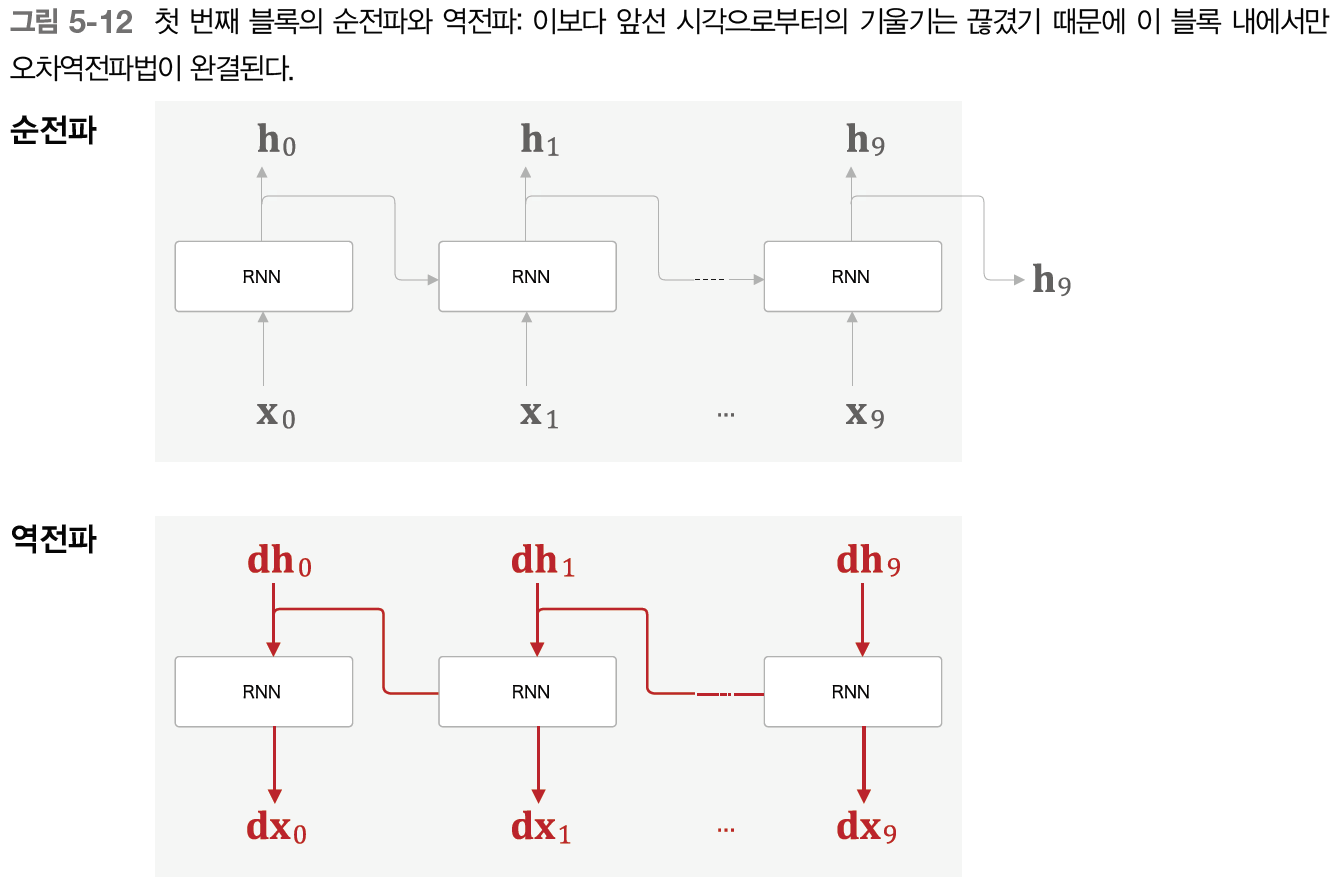

In [12]:
Image.open(os.path.join(img_path, 'fig 5-12.png'))

[그림 5-12]에서 보듯, 먼저 순전파를 수행하고, 그다음 역전파를 수행한다. 이렇게 해서 원하는 기울기를 구할 수 있다.

이어서 다음 블록의 입력 데이터 $(\mathbf{x}_{10}, \mathbf{x}_{11}, \ldots, \mathbf{x}_{19})$ 를 입력해서 오차역전파법을 수행한다.

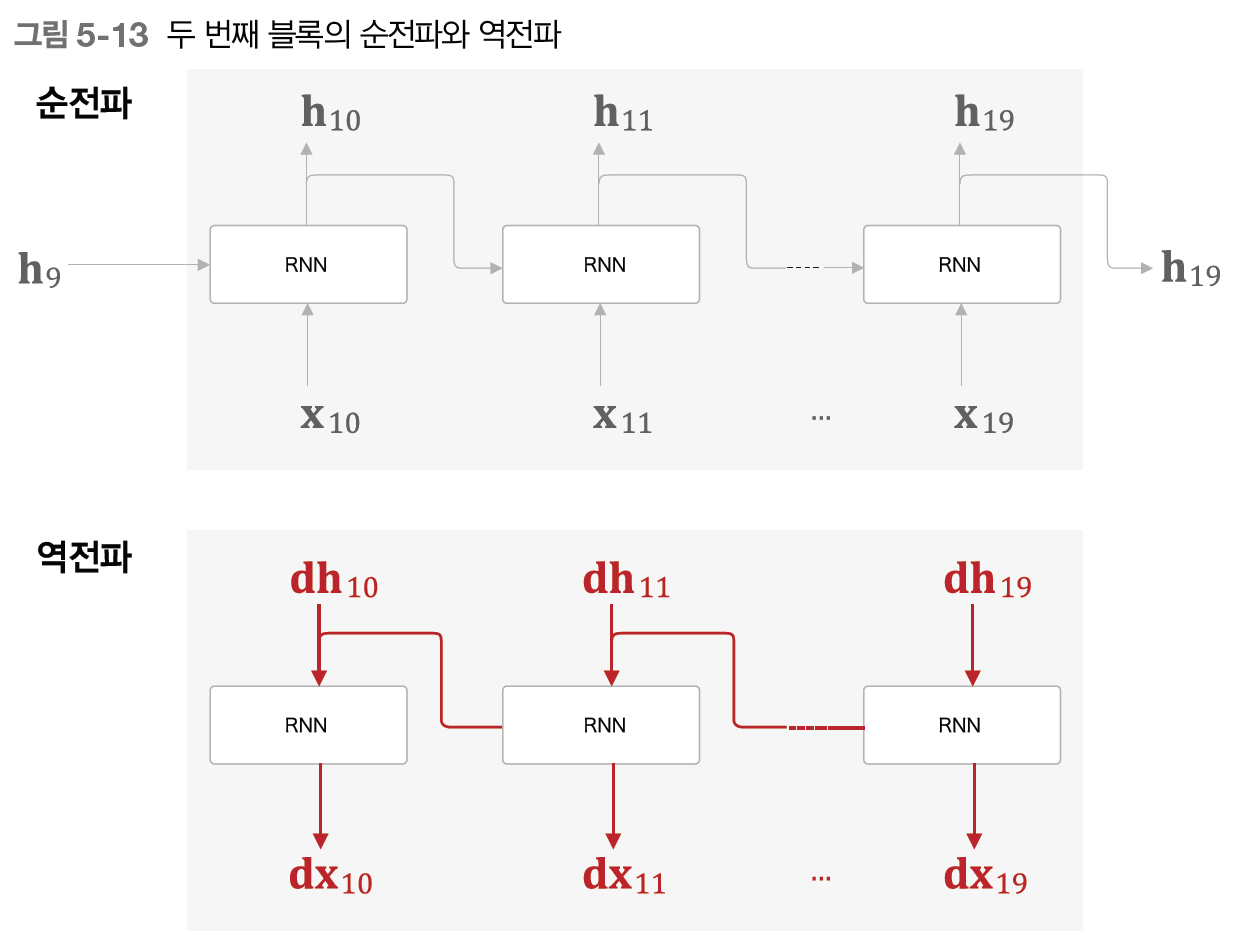

In [13]:
Image.open(os.path.join(img_path, 'fig 5-13.png'))

여기에서도 첫 번째 블록과 마찬가지로 순전파를 수행한 다음 역전파를 수행한다. 

그리고 여기서 중요한 점은 이번 순전파 계산에는 앞 블록의 마지막 은닉 상태인 $\mathbf{h}_9$ 가 필요하다는 것이다. 이를 통해 순전파는 계속 연결될 수 있다.

같은 요령으로, 이어서 3번째의 블록을 대상으로 학습을 수행한다.

이때도 두 번째 블록의 마지막 은닉 상태($\mathbf{h}_{19}$)를 이용한다.

이처럼 RNN 학습에서는 데이터를 순서대로 입력하며, 은닉 상태를 계승하면서 학습을 수행한다.

지금까지의 설명으로 RNN 학습의 흐름을 큰 그림으로 표현하면 다음과 같다.

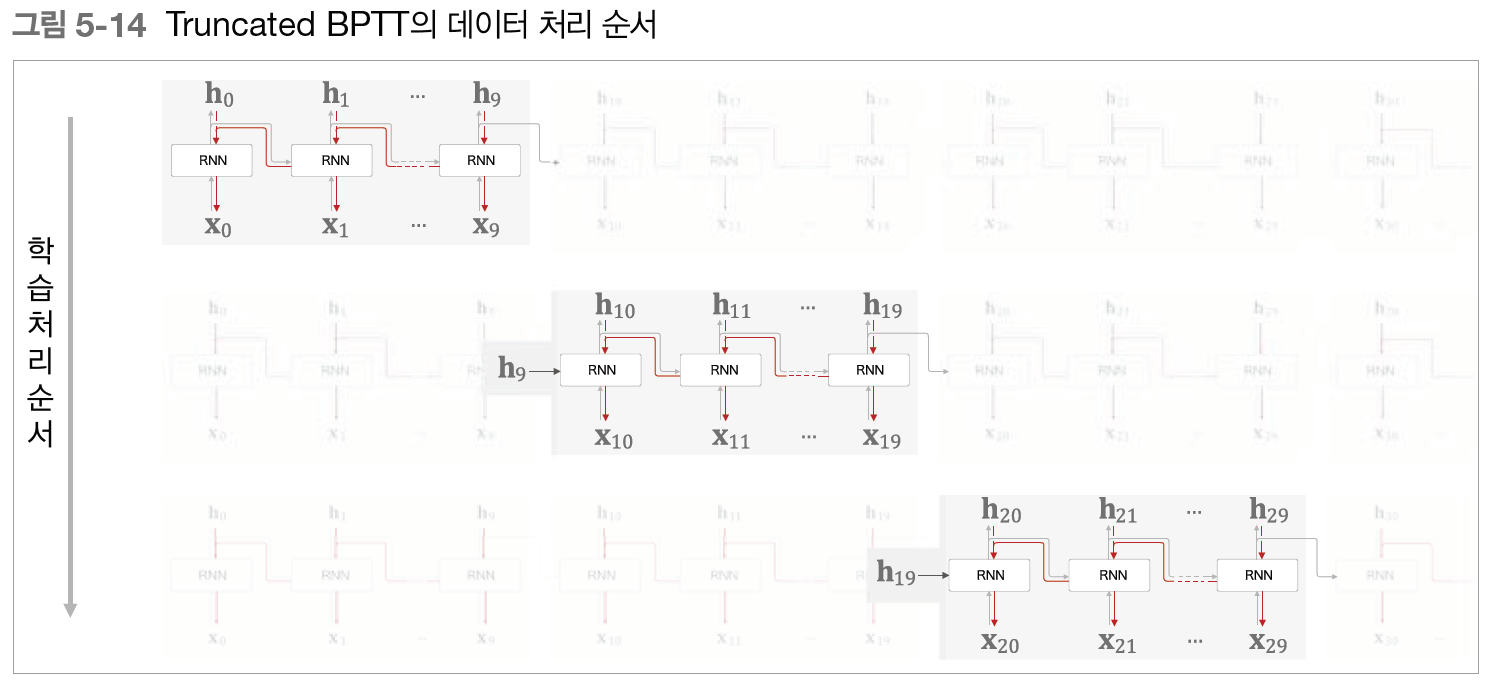

In [14]:
Image.open(os.path.join(img_path, 'fig 5-14.png'))

[그림 5-14]처럼 Truncated BPTT에서는 데이터를 순서대로 입력해서 학습한다.

이런 식으로 순전파의 연결을 유지하면서 블록 단위로 오차역전파법을 적용할 수 있다.

### 5.2.5 Truncated BPTT의 미니배치 학습

지금까지의 Truncated BPTT 이야기에서는 미니배치 수가 1일 때에 해당한다.

우리는 미니배치 학습을 수행하기 때문에, 원래대로라면 구체적인 배치 방식을 고려해서 [그림 5-14]처럼 데이터를 순서대로 입력해야 한다.

그렇게 하려면 데이터를 주는 시작 위치를 각 미니배치의 시작 위치로 '옮겨줘야' 한다.

앞서와 같은 예로, 길이가 1,000인 시계열 데이터에 대해서 시각의 길이를 10개 단위로 잘라 Truncated BPTT로 학습하는 경우를 가정한다.

그러면 이때 미니배치의 수를 두 개로 구성해서 학습하려면 어떻게 해야 할까?

이 경우 RNN 계층의 입력 데이터로, 첫 번째 미니배치(샘플 데이터) 때는 처음부터 순서대로 데이터를 제공한다.

그리고 두 번째 미니배치 때는 500번째의 데이터를 시작 위치로 정하고, 그 위치부터 다시 순서대로 데이터를 제공한다(시작 위치를 500만큼 '옮겨'준다).

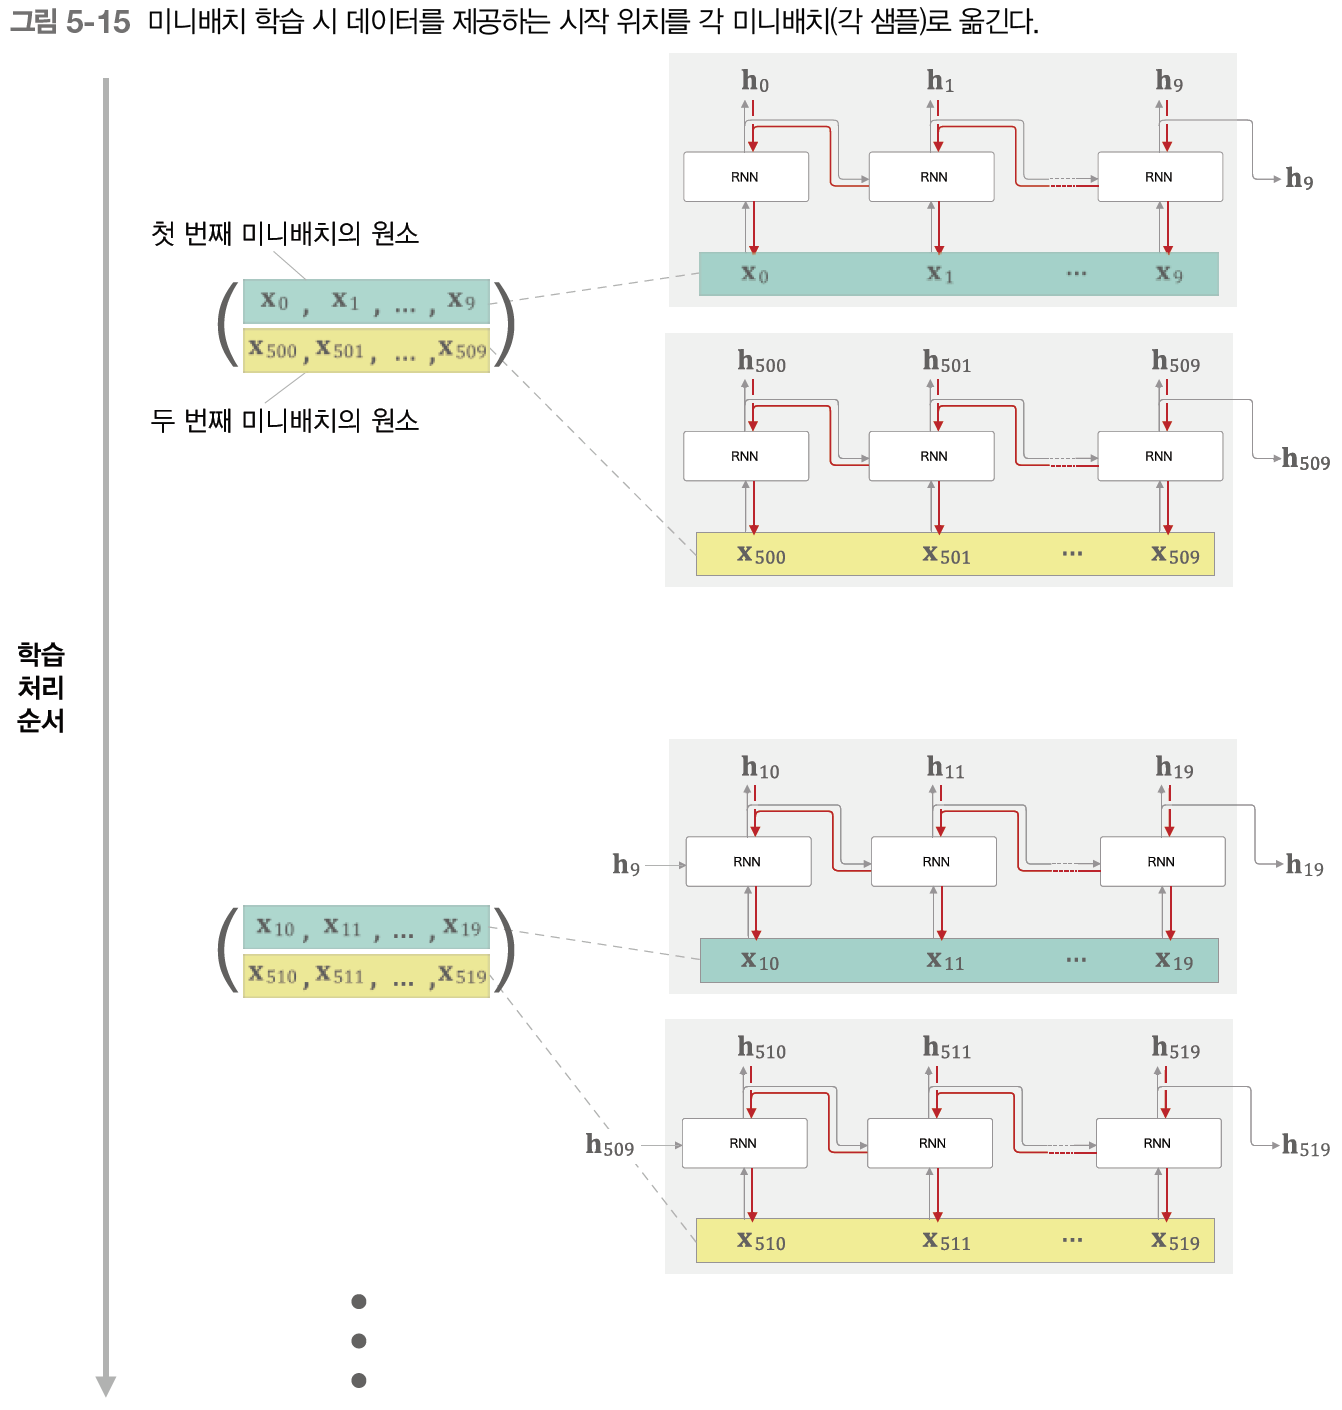

In [15]:
Image.open(os.path.join(img_path, 'fig 5-15.png'))

[그림 5-15]처럼 첫 번째 미니배치 원소는 $\mathbf{x}_0, \ldots, \mathbf{x}_9$ 이 되고, 두 번째 미니배치 원소는 $\mathbf{x}_{500}, \ldots, \mathbf{x}_{509}$ 가 된다. 

그리고 이 미니배치 데이터를 RNN의 입력 데이터로 사용해 학습을 수행한다. 이후로는 순서대로 진행되므로 다음에 넘길 데이터는 각각 시계열 데이터의 10~19번째, 510~519번째의 데이터가 되는 것이다.

이처럼 미니배치 학습을 수행할 때는 각 미니배치의 시작 위치를 오프셋으로 옮겨준 후 순서대로 제공하면 된다.

또한 데이터를 순서대로 입력하다가 끝에 도달하면 다시 처음부터 입력하도록 한다.

지금까지 살펴본 것처럼 Truncated BPTT의 원리는 단순하지만, '데이터 제공 방법'면에서는 몇 가지를 주의해야 한다.

구체적으로는 '데이터를 순서대로 제공하기'와 '미니배치별로 데이터를 제공하는 시작 위치를 옮기기'이다.

## 5.3 RNN 구현

앞 절까지의 이야기에서 RNN의 전체 모습을 볼 수 있었다. 지금부터 구현해야 할 것은 결국 가로 방향으로 성장한 신경망이다.

그리고 Truncated BPTT 방식의 학습을 따른다면, 가로 크기가 일정한 일련의 신경망을 만들면 된다.

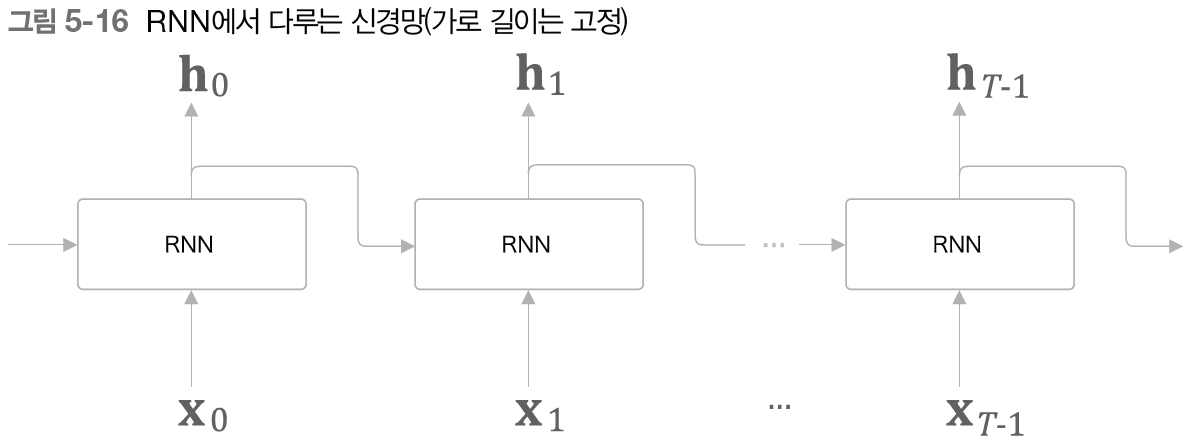

In [16]:
Image.open(os.path.join(img_path, 'fig 5-16.png'))

[그림 5-16]에서 보듯, 우리가 다룰 신경망은 길이가 $T$ 인 시계열 데이터를 받는다($T$ 는 임의의 값).

그리고 각 시각의 은닉 상태를 $T$ 개 출력한다. 그리고 모듈화를 생각해서, 옆으로 성장한 [그림 5-16]의 신경망을 '하나의 계층'으로 구현한다.

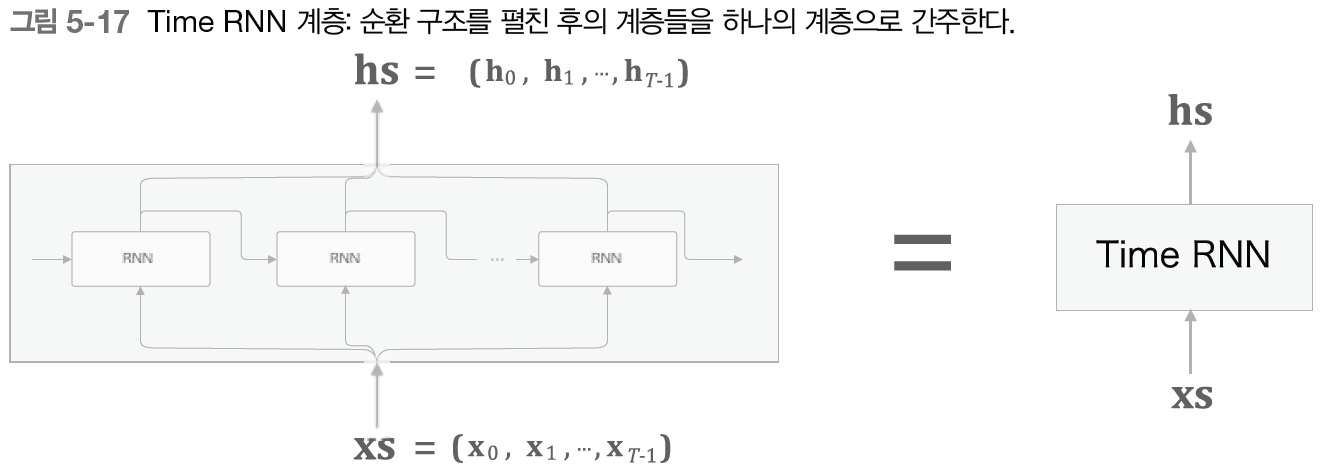

In [17]:
Image.open(os.path.join(img_path, 'fig 5-17.png'))

[그림 5-17]과 같이 상하 방향의 입력과 출력을 각각 하나로 묶으면 옆으로 늘어선 일련의 계층을 하나의 계층으로 간주할 수 있다. 

즉, $(\mathbf{x}_0, \mathbf{x}_1, \ldots, \mathbf{x}_{T-1})$ 을 묶은 $\mathbf{xs}$ 를 입력하면 $(\mathbf{h}_0, \mathbf{h}_1, \ldots, \mathbf{h}_{T-1})$ 을 묶은 $\mathbf{hs}$ 를 출력하는 단일 계층으로 볼 수 있게 된다.

이때 Time RNN 계층 내에서 한 단계의 작업을 수행하는 계층을 'RNN 계층'이라 하고, $T$ 개 단계분의 작업을 한꺼번에 처리하는 계층을 'Time RNN 계층'이라 한다.

$\textbf{NOTE}$

Time RNN 같이 시계열 데이터를 한꺼번에 처리하는 계층에는 앞에 'Time'을 붙이도록 한다. 이는 이 책의 독자적인 명명규칙이다.

앞으로 할 구현의 흐름은 다음과 같다.

1. RNN 구현 : RNN의 한 단계를 처리하는 클래스
2. TimeRNN 구현 : RNN 클래스를 이용해 $T$ 개 단계의 처리를 한꺼번에 수행하는 클래스

### 5.3.1 RNN 계층 구현

RNN의 순전파를 remind하면 다음과 같다.

\begin{equation*}
    \mathbf{h}_{t} = \tanh (\mathbf{h}_t \mathbf{W}_{\mathbf{h}} + \mathbf{x}_t \mathbf{W}_{\mathbf{x}} + \mathbf{b}), \quad t \geq 1
    \tag{5.7}
\end{equation*}

여기서 우리는 데이터를 미니배치로 모아 처리한다. 따라서 $\mathbf{x}_t$ 와 $\mathbf{h}_t$ 에는 각 샘플 데이터를 행 방향에 저장한다.

또한 미니배치 크기가 $N$, 입력 벡터의 차원 수가 $D$, 은닉 상태 벡터의 차원 수가 $H$라면 지금 계산에서의 형상 확인은 다음과 같다.

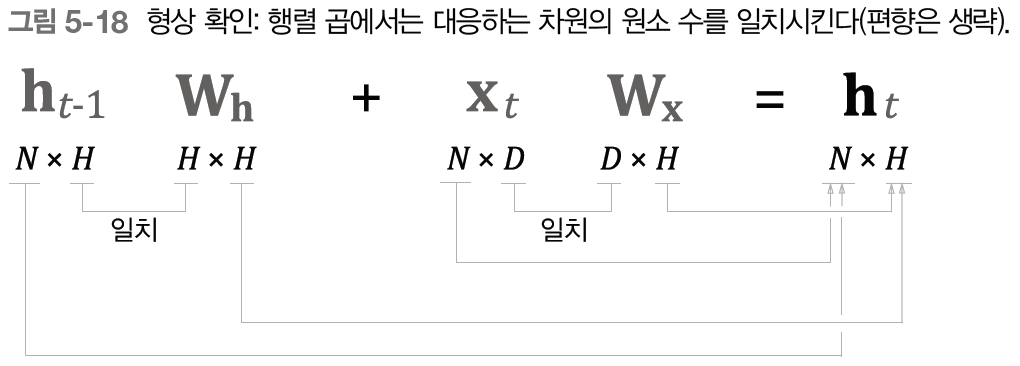

In [18]:
Image.open(os.path.join(img_path, 'fig 5-18.png'))

RNN 클래스의 초기화와 순전파 메서드 (common/time_layers.py)

RNN의 초기화 메서드는 가중치 2개와 편향 1개를 인수로 받는다. 여기에서는 인수로 받은 매개변수를 인스턴스 변수 `params`에 리스트로 저장한다. 

그리고 각 매개변수에 대응하는 형태로 기울기를 초기화한 후 `grads`에 저장한다. 마지막으로 역전파 계산 시 사용하는 중간 데이터를 담을 `cache`를 None으로 초기화한다.

순전파인 `forward(x, h_prev)` 메서드에서는 인수 2개(아래로부터의 입력 `x`와 왼쪽으로부터의 입력 `h_prev`)를 받는다.

그 다음은 식 (5.7)을 그대로 코드로 옮긴 것 뿐이다. 이때 바로 이전의 RNN 계층으로부터 받는 입력이 `h_prev`이고,

현 시각 RNN 계층으로부터의 출력(= 다음 시각 계층으로의 입력)은 `h_next`이다.

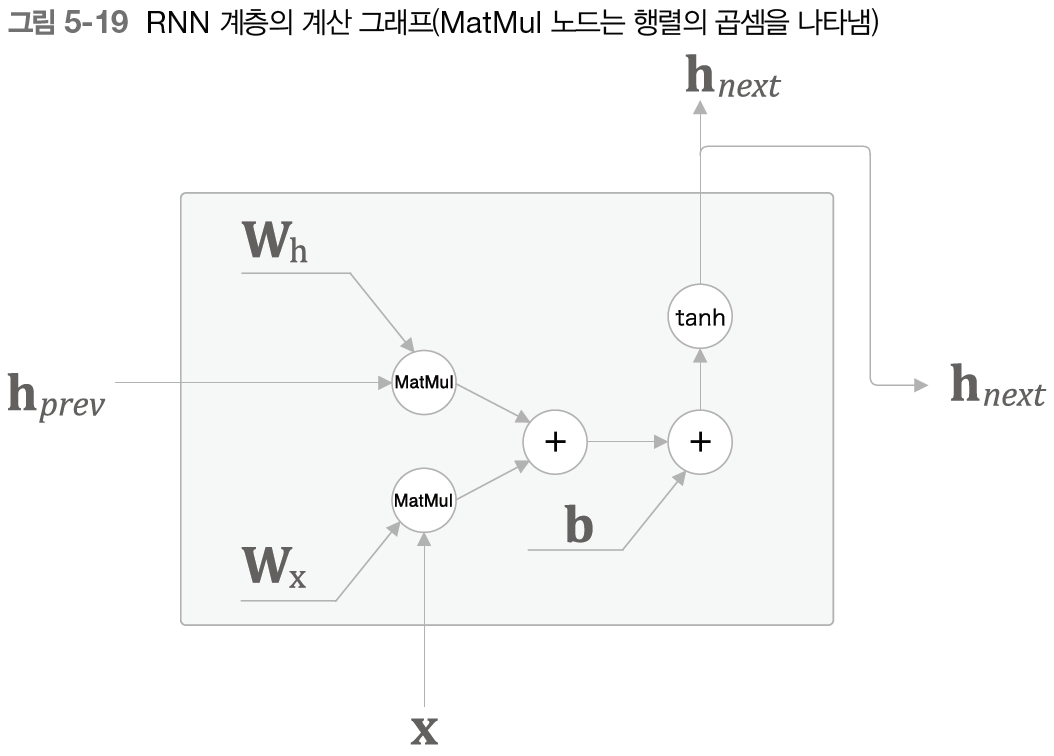

In [19]:
Image.open(os.path.join(img_path, 'fig 5-19.png'))

RNN 계층의 순전파는 [그림 5-19]와 같은 계산 그래프로 나타낼 수 있다.

역전파의 계산 그래프는 [그림 5-20]과 같다.

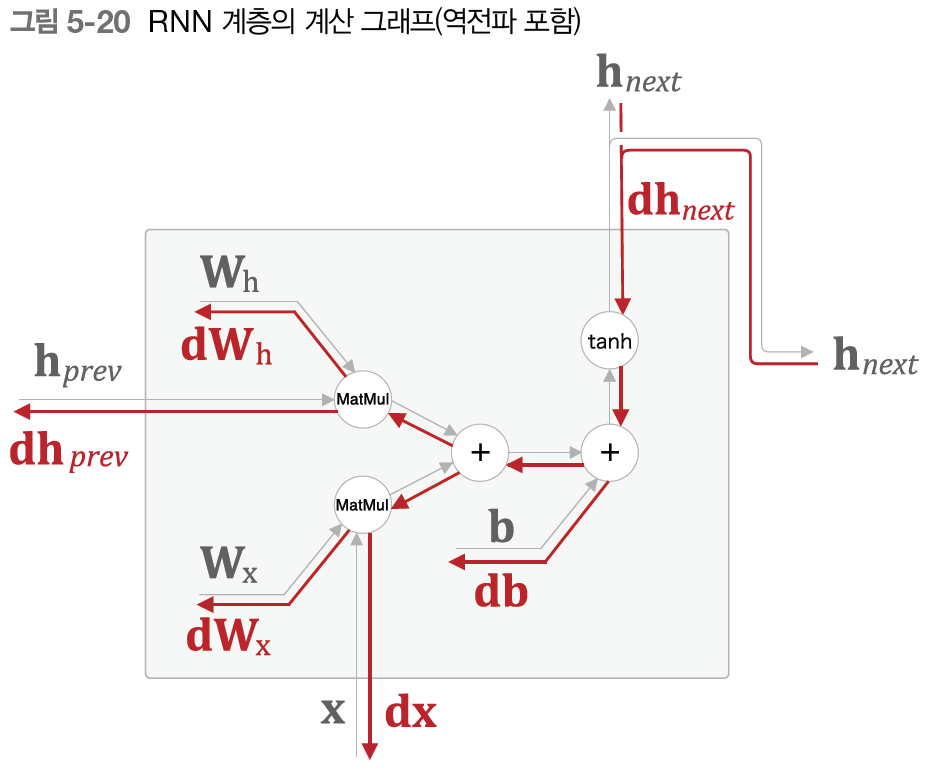

In [20]:
Image.open(os.path.join(img_path, 'fig 5-20.png'))

### 5.3.2 Time RNN 계층 구현

Time RNN 계층은 $T$ 개의 RNN 계층으로 구성된다 ($T$ 는 임의의 수로 설정할 수 있다).

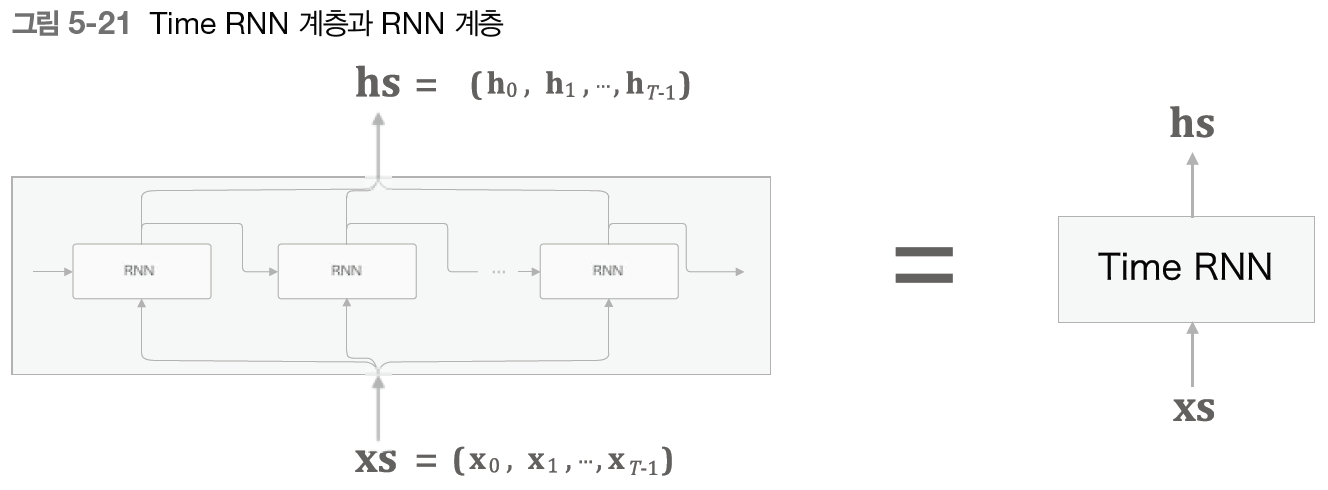

In [21]:
Image.open(os.path.join(img_path, 'fig 5-21.png'))

[그림 5-21]에서 보듯, Time RNN 계층은 RNN 계층 $T$ 개를 연결한 신경망이다. 이 신경망을 TimeRNN 클래스로 구현하고자 한다.

그리고 여기서는 RNN 계층의 은닉 상태 $\mathbf{h}$ 를 인스턴스 변수로 유지한다. 이 변수를 [그림 5-22]처럼 은닉 상태를 '인계'받는 용도로 사용한다.

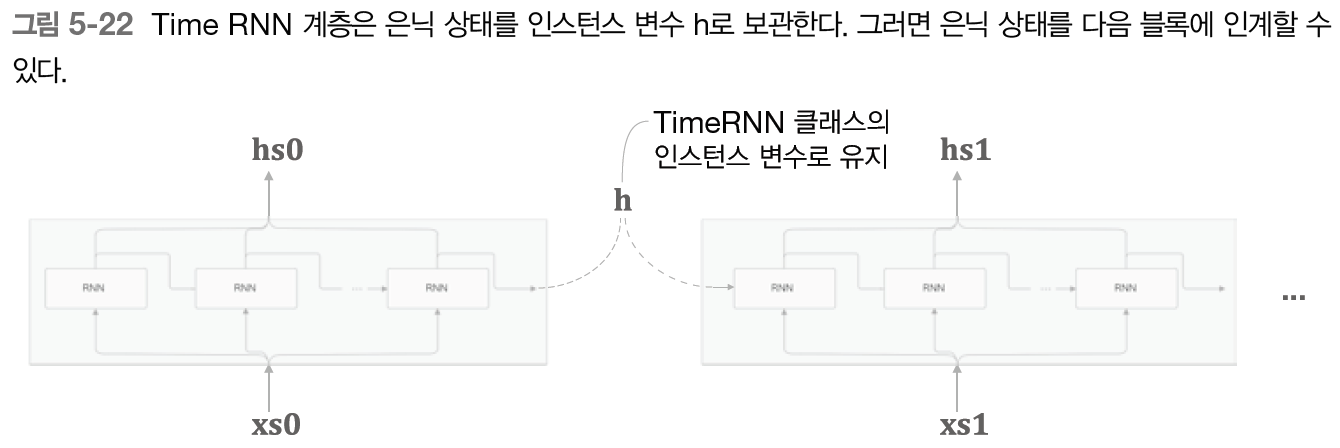

In [22]:
Image.open(os.path.join(img_path, 'fig 5-22.png'))

[그림 5-22]처럼 우리는 RNN 계층의 은닉 상태를 Time RNN 계층에서 관리하기로 한다.

이렇게 하면 Time RNN 사용자는 RNN 계층 사이에서 은닉 상태를 '인계하는 작업'을 생각하지 않아도 된다는 장점이 생긴다.

그리고 이 책에서는 은닉 상태를 인계받을지의 여부에 관한 기능을 `stateful`이라는 인수로 조정할 수 있도록 한다.

Time RNN 계층 코드 (common/time_layers.py)

초기화 메서드는 가중치와 편향, 그리고 `stateful`이라는 불리언 값(`True/False`)을 인수로 받는다.

인스턴스 변수 중 `layers`는 다수의 RNN 계층을 리스트로 저장하는 용도이다.

그리고 인스턴스 변수 `h`는 `forward()`메서드를 불렀을 때의 마지막 RNN 계층의 은닉 상태를 저장하고,

`dh`는 `backward()`를 불렀을 때 하나 앞 블록의 은닉 상태의 기울기를 저장한다.

$\textbf{WARNING}$

TimeRNN 클래스는 확장성을 고려해서 Time RNN 계층의 은닉 상태를 설정하는 메서드를 `set_state(h)`로, 은닉상태를 초기화하는 메서드를 `reset_state()`로 구현한다.

앞의 인수 중 `stateful`은 '상태가 있는'이란 뜻의 단어이다. 이 책의 구현에서는 `stateful`이 `True`일 때, Time RNN 계층은 '상태가 있다'라고 말한다.

여기서 말하는 '상태가 있다'란, Time RNN계층이 은닉 상태를 유지한다는 뜻이다. 즉, 아무리 긴 시계열 데이터라도 Time RNN 계층의 순전파를 끊지 않고 전파한다는 뜻이다.

한편, `stateful`이 `False`일 때의 Time RNN 계층은 은닉 상태를 '영행렬'(모든 요소가 0인 행렬)로 초기화한다. 이것은 상태가 없는 모드이며, '무상태'라고 한다.

$\textbf{NOTE}$

긴 시계열 데이터를 처리할 때는 RNN의 은닉 상태를 유지해야 한다. 이처럼 은닉 상태를 유지하는 기능을 흔히 `stateful`이라는 단어로 표현한다. 많은 딥러닝 프레임워크에서 RNN 계층을 살펴보면 인수로 `stateful`이라는 것을 받으며, 이를 통해 이전 시각의 은닉 상태를 유지할지 지정할 수 있다.

TimeRNN 클래스의 순전파 메서드인 `forward(xs)`는 아래로부터 입력 `xs`를 받는다. `xs`는 $T$ 개 분량의 시계열 데이터를 하나로 모은 것이다.

따라서 미니배치 크기를 $N$, 입력 벡터의 차원 수를 $D$ 라고 하면 `xs`의 형상은 $(N, T, D)$ 가 된다.

RNN 계층의 은닉 상태 `h`는 처음 호출 시 (`self.h`가 `None`일 때)에는 원소가 모두 0인 영행렬로 초기화된다.

기본 구현에서는 처음 `hs = np.empty((N, T, H), dtype = 'f')`문장에서 출력값을 담을 그릇 (`hs`)을 준비한다.

이어서 총 `T`회 반복되는 `for`문 안에서 RNN 계층을 생성하여 인스턴스 변수 `layers`에 추가한다.

그 사이에 RNN 계층이 각 시각 `t`의 은닉 상태 `h`를 계산하고, 이를 `hs`에 해당 인덱스(시각)의 값으로 설정한다.

$\textbf{NOTE}$

Time RNN 계층의 `forward()` 메서드가 불리면, 인스턴스 변수 `h`에는 마지막 RNN 계층의 은닉상태가 저장된다. 그래서 다음번 `forward()`메서드 호출 시 `stateful`이 `True`면 먼저 저장된 `h`값이 그대로 이용되고, `stateful`이 `False`면 `h`가 다시 영행렬로 초기화된다.

Time RNN 계층의 역전파 계산 그래프는 다음과 같다.

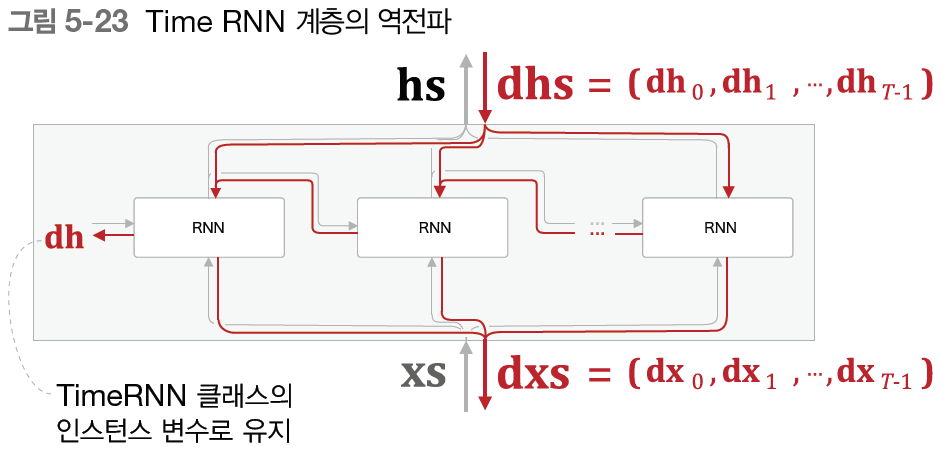

In [23]:
Image.open(os.path.join(img_path, 'fig 5-23.png'))

[그림 5-23]과 같이, 여기서는 상류(출력 쪽 층)에서부터 전해지는 기울기를 $\mathbf{dhs}$ 로 쓰고, 하류로 내보내는 기울기를 $\mathbf{dxs}$ 로 쓴다.

여기에서 우리는 Truncated BPTT를 수행하기 때문에 이 블록의 이전 시각 역전파는 필요하지 않다.

단, 이전 시각의 은닉 상태 기울기는 인스턴스 변수 `dh`에 저장하도록 한다. (7장에서 다루는 `seq2seq`에 쓰인다)

이상이 Time RNN 계층에서 이뤄지는 역전파의 전체 그림이다. 이때 `t`번째의 RNN 계층에 주목하면, 그 역전파는 [그림 5-24]처럼 그릴 수 있다.

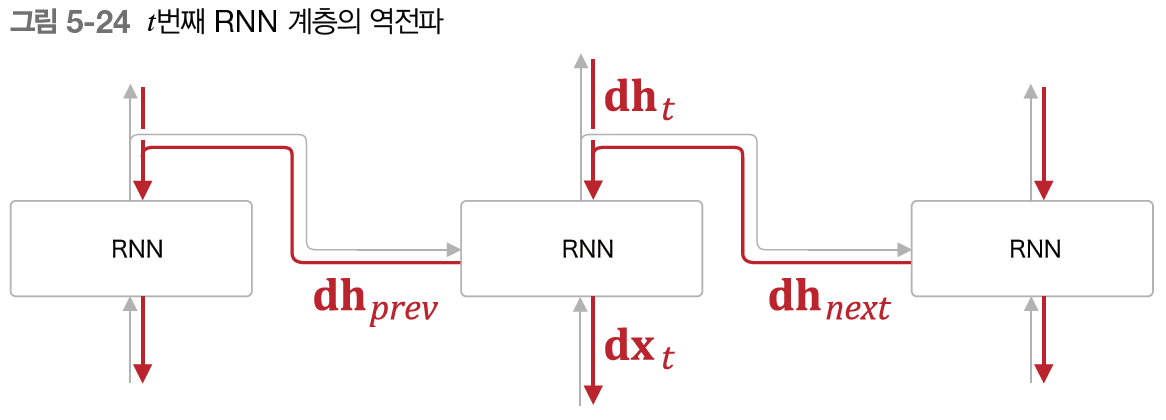

In [24]:
Image.open(os.path.join(img_path, 'fig 5-24.png'))

`t`번째 RNN 계층에서는 위로부터의 기울기 $\mathbf{dh}_t$ 와 '한 시각 뒤(미래) 계층'으로부터의 기울기 $\mathbf{dh}_{\text{next}}$ 가 전해진다.

여기서의 주의점은 RNN 계층의 순전파에서는 출력이 2개로 분기된다는 것이다.

순전파 시 분기했을 경우, 그 역전파에서는 각 기울기가 합산되어 전해진다. 따라서 역전파 시 RNN 계층에는 합산된 기울기 ($\mathbf{dh}_t + \mathbf{dh}_{\text{next}}$) 가 입력된다.

그리고 가장 먼저 하류로 흘려보낼 기울기를 담을 그릇인 `dxs`를 만든다. 순전파 때와는 반대 순서로 RNN 계층의 `backward()` 메서드를 호출하여, 

각 시각의 기울기 `dx`를 구해서 `dxs`의 해당 인덱스(시각)에 저장한다.

그리고 가중치 매개변수에 대해서도 각 RNN 계층의 가중치 기울기를 합산하여 최종 결과를 멤버 변수 `self.grads`에 덮어쓴다.

$\textbf{WARNING}$

Time RNN 계층 안에는 RNN 계층이 여러 개 있다. 그리고 그 RNN 계층들에서 똑같은 가중치를 사용하고 있다.

따라서 Time RNN 계층의 (최종) 가중치 기울기는 각 RNN 계층의 가중치 기울기를 모두 더한게 된다.

## 5.4 시계열 데이터 처리 계층 구현

이번 장의 목표는 RNN을 사용하여 '언어 모델'을 구현하는 것이다.

지금까지 RNN 계층과 시계열 데이터를 한꺼번에 처리하는 Time RNN 계층을 구현했는데, 이번 절에서는 시계열 데이터를 처리하는 계층을 몇 개 더 만든다.

또한, RNN을 사용한 언어 모델은 영어로 RNN Language Model 이므로 앞으로 RNNLM이라 칭한다.

### 5.4.1 RNNLM의 전체 그림

먼저 RNNLM에서 사용되는 신경망을 한번 보고 시작한다. 왼쪽은 RNNLM의 계층 구성이고, 오른쪽은 이를 시간축으로 펼친 신경망이다.

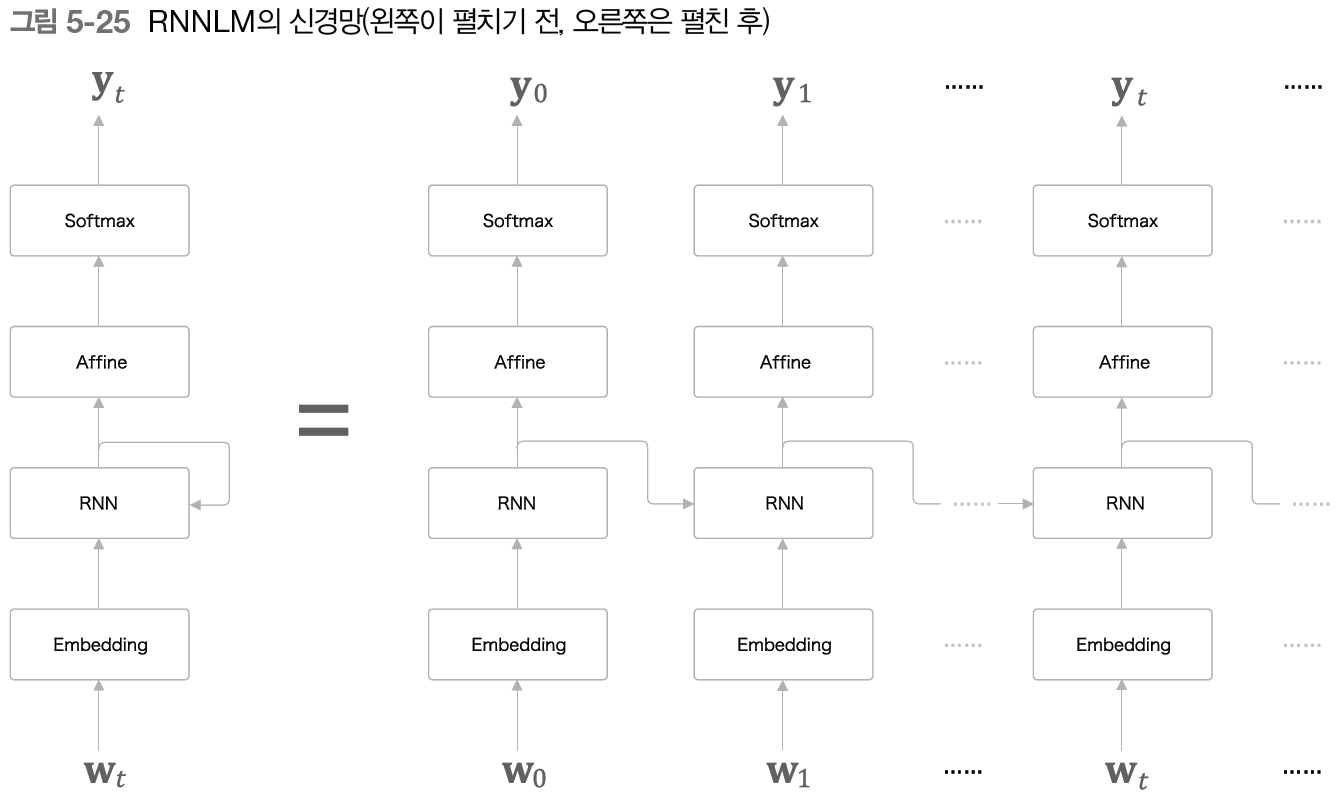

In [25]:
Image.open(os.path.join(img_path, 'fig 5-25.png'))

[그림 5-25]의 첫 번째(가장 아래) 층은 Embedding 계층이다. 이 계층은 단어 ID를 단어의 분산 표현(단어 벡터)으로 변환한다.

그리고 그 분산 표현이 RNN 계층으로 입력된다. RNN 계층은 은닉 상태를 다음 층으로(위쪽으로) 출력함과 동시에, 다음 시각의 RNN 계층으로(오른쪽으로) 출력한다.

그리고 RNN 계층이 위로 출력한 은닉 상태는 Affine 계층을 거쳐 Softmax 계층으로 전해진다.

그럼 [그림 5-25]의 신경망에서 순전파로 한정해서, 구체적인 데이터를 흘려보면서 출력 결과를 관찰해본다.

입력 데이터로는 친숙한 문장인 "You say goodbye and I say hello."를 사용한다.

이때 RNNLM에서 이뤄지는 처리는 [그림 5-26]과 같게 된다.

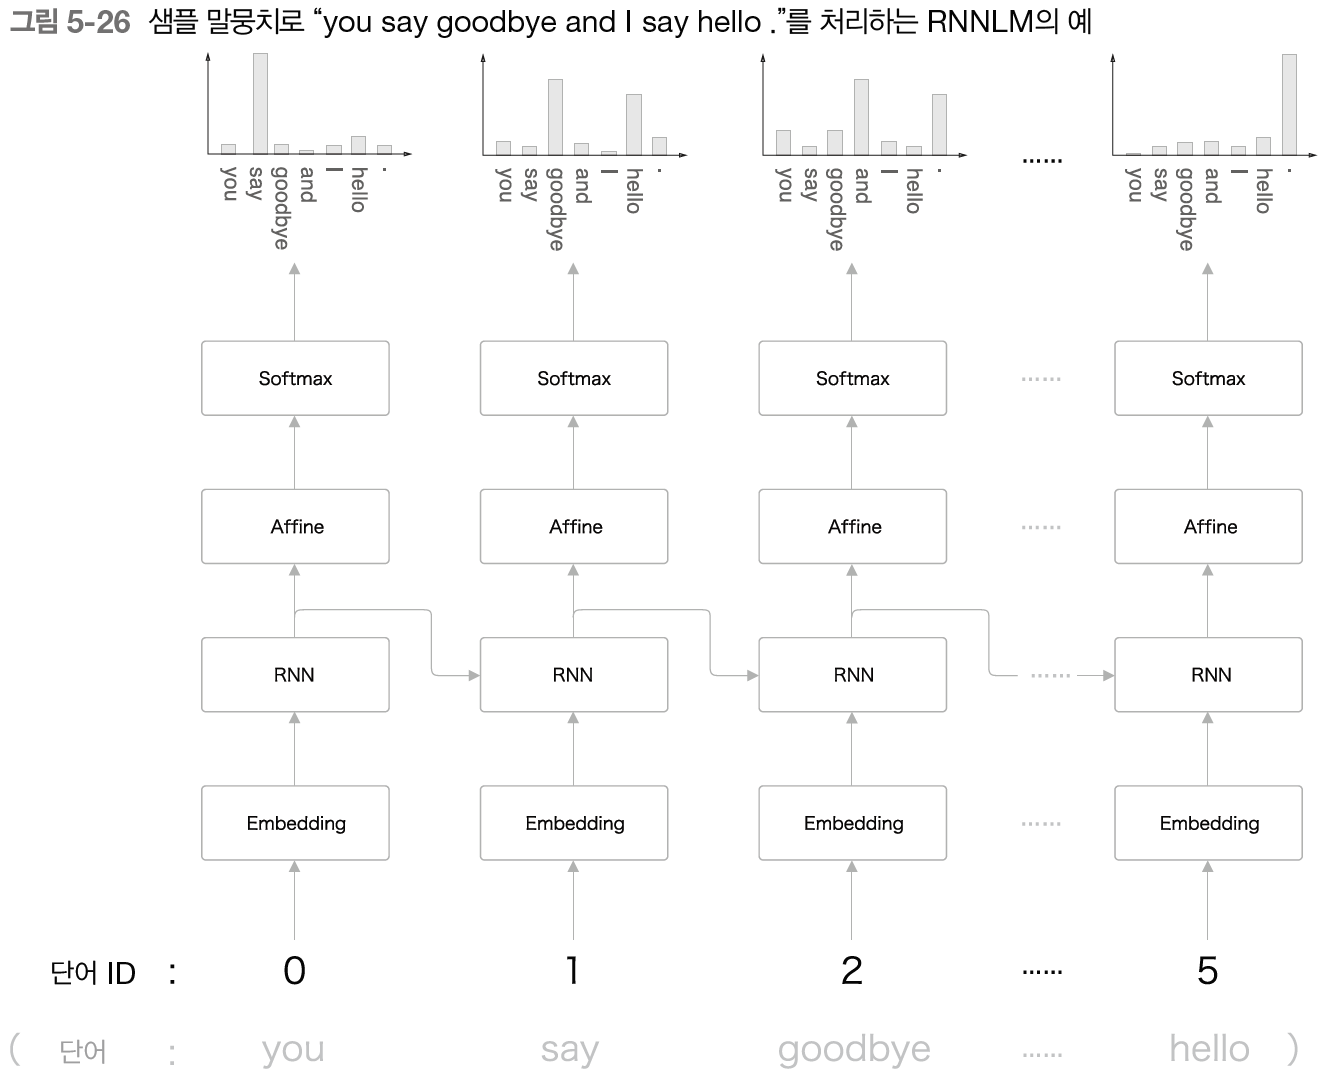

In [26]:
Image.open(os.path.join(img_path, 'fig 5-26.png'))

[그림 5-26]에서처럼 입력 데이터는 단어 ID의 배열이다. 우선 첫 번째 시각에 주목해본다.

여기에서는 첫 단어로 단어 ID가 0인 "you"가 입력된다. 이때 Softmax 계층이 출력하는 확률분포를 보면 "say"에서 가장 높게 나온 것을 알 수 있다. 

다시 말해 "you" 다음에 출현하는 단어가 "say"라는 것을 올바르게 예측한다. 당연하지만 이와 같이 제대로 예측하려면 좋은 가중치(잘 학습된 가중치)를 사용해야 한다.

이어서 두 번째 단어인 "say"를 입력하는 부분에 주목해본다.

이때의 Softmax 계층 출력은 "goodbye"와 "hello" 두 곳에서 높게 나왔다. 확실히 "you say goodbye"와 "you say hello"는 모두 자연스러운 문장이다.

여기서 주목할 것은 RNN 계층은 "you say"라는 맥락을 '기억'하고 있다는 사실이다.

더 정확하게 말하면, RNN은 "you say"라는 과거의 정보를 응집된 은닉 상태 벡터로 저장해두고 있다.

그러한 정보를 더 위의 Affine 계층에, 그리고 다음 시각의 RNN 계층에 전달하는 것이 RNN 계층이 하는 일이다.

이처럼 RNNLM은 지금까지 입력된 단어를 '기억'하고, 그것을 바탕으로 다음에 출현할 단어를 예측한다. 이 일을 가능하게 하는 비결이 바로 RNN 계층의 존재이다.

RNN 계층이 과거에서 현재로 데이터를 계속 흘려보내줌으로써 과거의 정보를 인코딩해 저장(기억)할 수 있는 것이다.

### 5.4.2 Time 계층 구현

지금까지는 시계열 데이터를 한꺼번에 처리하는 계층을 Time RNN 이라는 이름의 계층으로 구현했다.

이번 절에서도 마찬가지로, 시계열 데이터를 한꺼번에 처리하는 계층을 Time Embedding, Time Affine 형태의 이름으로 구현하고자 한다.

이러한 Time 계층들을 다 만들면 우리가 원하는 신경망을  [그림 5-27] 형태로 구현할 수 있다.

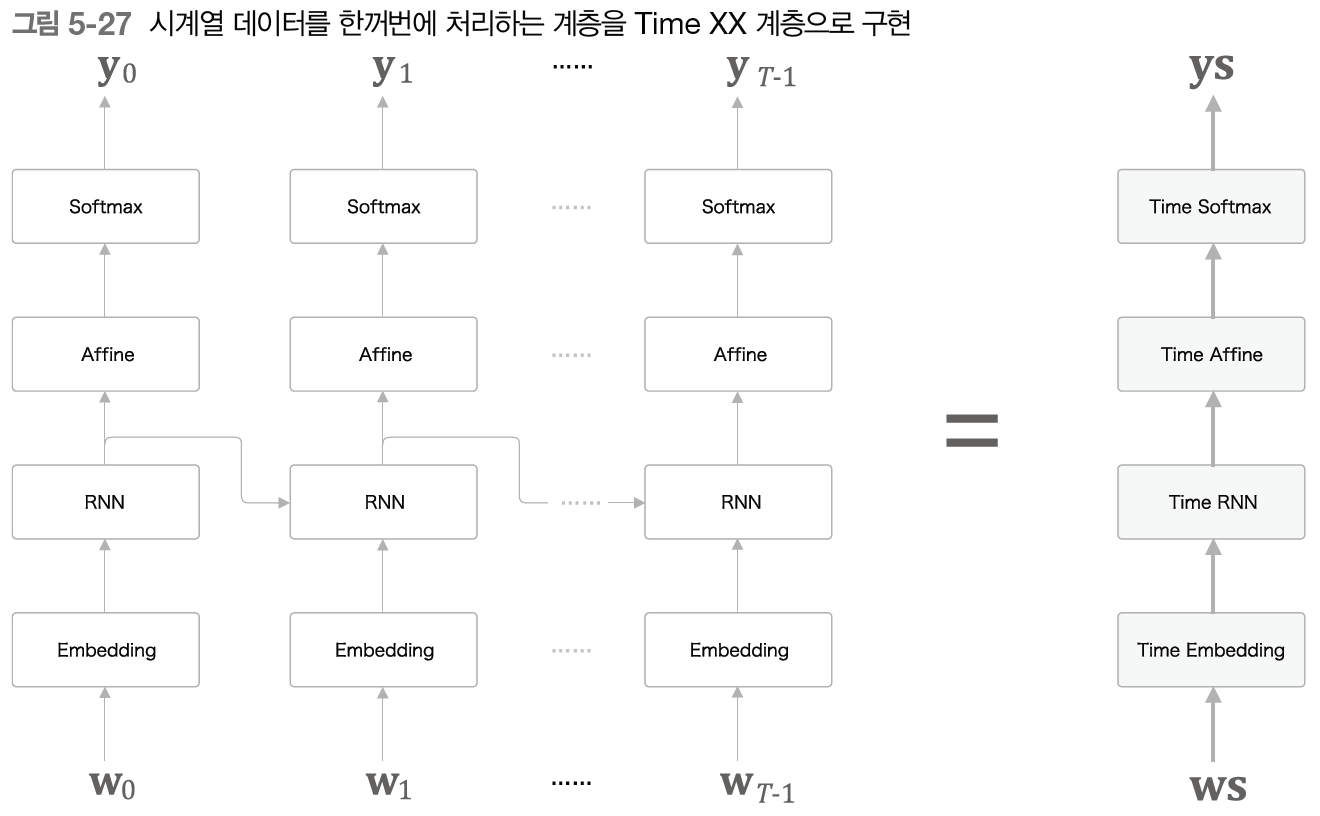

In [27]:
Image.open(os.path.join(img_path, 'fig 5-27.png'))

Time 계층은 간단하게 구현할 수 있다. 예컨대 Time Affine 계층은 [그림 5-28]처럼 Affine 계층을 $T$ 개 준비해서, 각 시각의 데이터를 개별적으로 처리하면 된다.

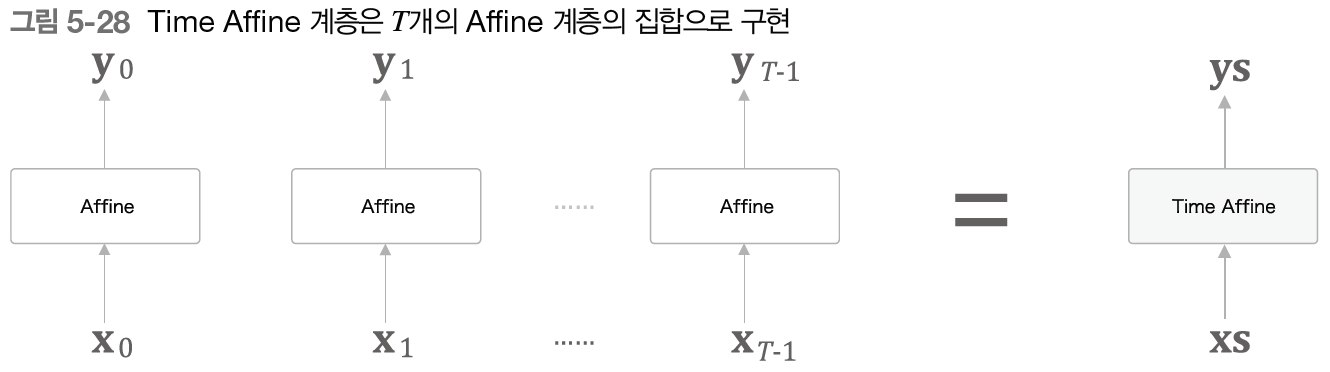

In [28]:
Image.open(os.path.join(img_path, 'fig 5-28.png'))

Time Embedding 계층 역시 순전파 시에 $T$ 개의 Embedding 계층을 준비하고 각 Embedding 계층이 각 시각의 데이터를 처리한다.

참고로, Time Affine 계층은 단순히 Affine 계층 $T$ 개를 이용하는 방식 대신 행렬 계산으로 한꺼번에 처리하는, 효율 좋은 방식으로 구현한다(common/time_layers.py 의 TimeAffine 클래스).

계속해서 시계열 버전의 Softmax를 살펴본다. Softmax 계층을 구현할 때는 손실 오차를 구하는 Cross Entropy Error 계층도 함께 구현한다.

여기에서는 [그림 5-29]와 같은 구성의 Time Softmax with Loss 계층으로 구현한다.

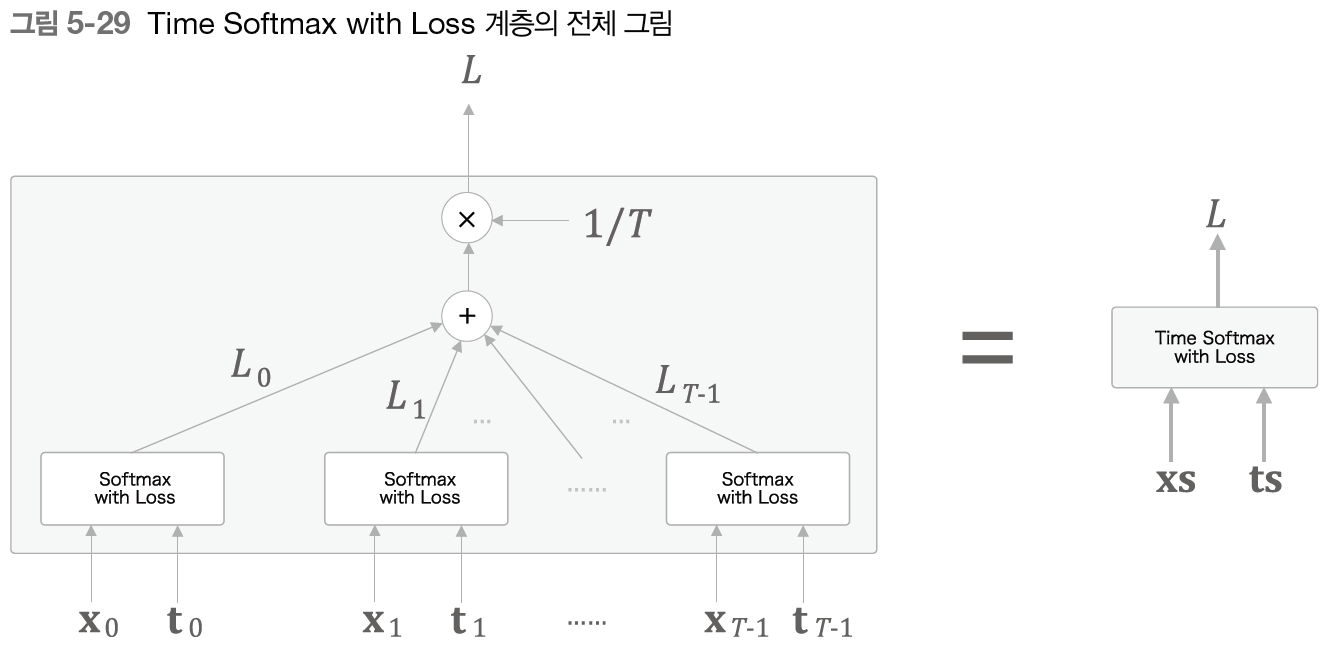

In [29]:
Image.open(os.path.join(img_path, 'fig 5-29.png'))

[그림 5-29]에서 $\mathbf{x}_0$ 나 $\mathbf{x}_1$ 등의 데이터는 아래층에서부터 전해지는 '점수'를 나타낸다.(확률로 정규화되기 전의 값)

또한, $\mathbf{t}_0$ 나 $\mathbf{t}_1$ 등의 데이터는 정답 레이블을 나타낸다. 

그림에서 보듯, $T$ 개의 Softmax with Loss 계층 각각이 손실을 산출한다. 그리고 그 손실들을 합산해 평균한 값이 최종 손실이 된다.

\begin{equation*}
    L = \cfrac{1}{T} (L_0 + L_1 + \cdots + L_{T-1})
    \tag{5.8}
\end{equation*}

그런데 이 책의 Softmax with Loss 계층은 미니배치에 해당하는 손실의 평균을 구했다.

무슨 말이냐 하면, 데이터 $N$ 개짜리 미니배치라면 그 $N$ 개의 손실을 더해 다시 $N$ 으로 나눠 데이터 1개당 평균 손실을 구했다.

이와 마찬가지로 Time Softmax with Loss 계층도 시계열에 대한 평균을 구하는 것으로, 데이터 1개당 평균 손실을 구해 최종 출력으로 내보낸다.

## 5.5 RNNLM 학습과 평가

### 5.5.1 RNNLM 구현

RNNLM에서 사용하는 신경망을 SimplRnnlm이라는 이름의 클래스로 구현한다. SimpleRnnlm의 계층 구성은 [그림 5-30]과 같다.

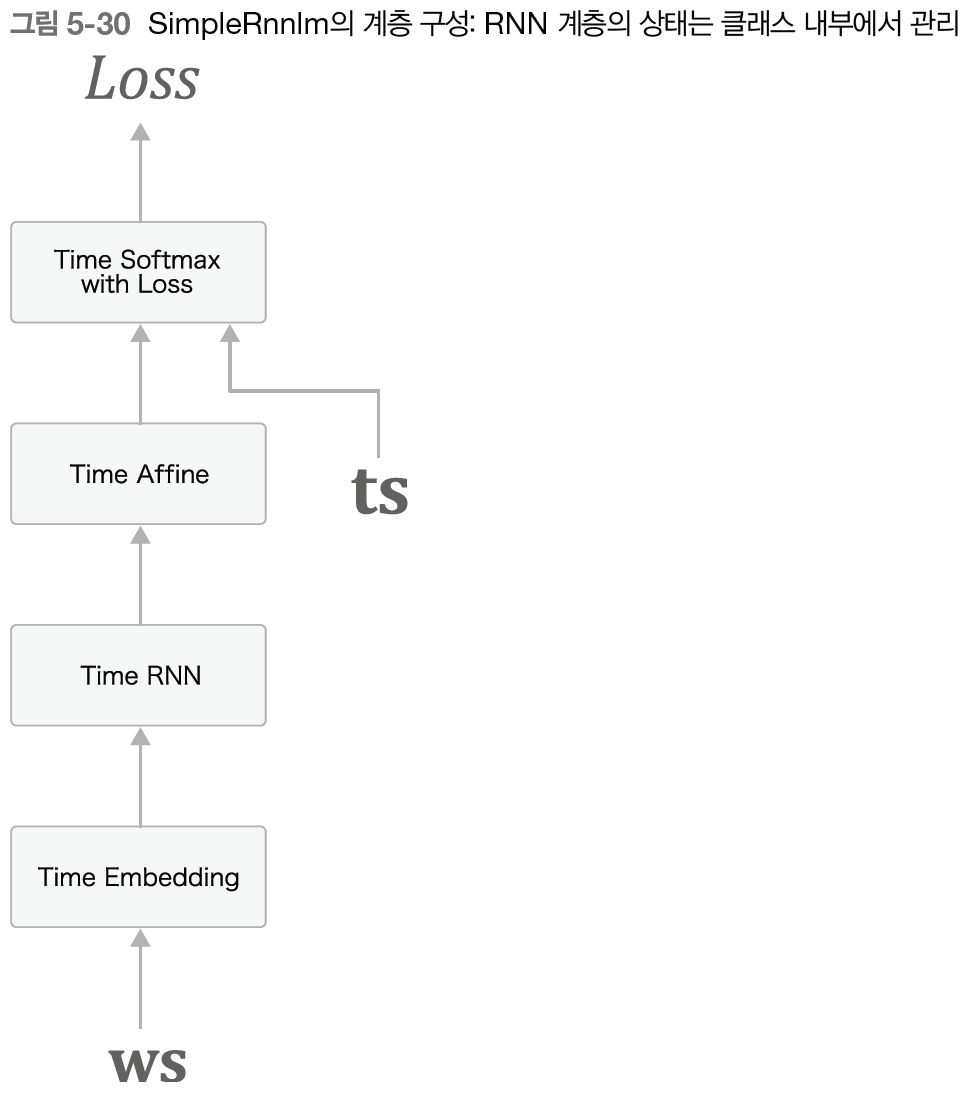

In [30]:
Image.open(os.path.join(img_path, 'fig 5-30.png'))

[그림 5-30]과 같이 SimpleRnnlm 클래스는 4개의 Time 계층을 쌓은 신경망이다. (chapter05/simple_rnnlm.py)

여기서 초기화 메서드는 각 계층에서 사용하는 매개변수(가중치와 편향)를 초기화하고 필요한 계층을 생성한다.

또, Truncated BPTT로 학습한다고 가정하여 Time RNN 계층의 `stateful`을 `True`로 설정했다. 그 결과 Time RNN 계층은 이전 시각의 은닉 상태를 계승할 수 있게 된다.

또한, 이 초기화 코드는 RNN계층과 Affine계층에서 '$\textbf{Xaiver 초깃값}^{\text{자비에르 초깃값}}$'을 이용했다.

Xavier 초깃값에서는 이전 계층의 노드가 $n$ 개라면 표준편차가 $\tfrac{1}{\sqrt{n}}$ 인 분포로 값들을 초기화한다.

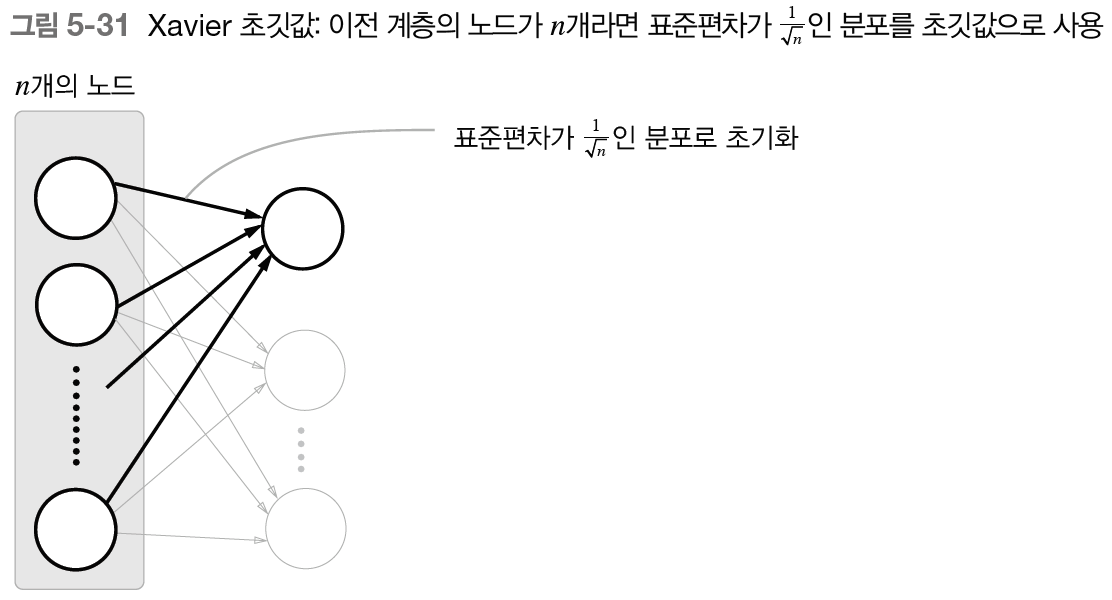

In [31]:
Image.open(os.path.join(img_path, 'fig 5-31.png'))

그 외의 구현은 간단하다. 각각의 계층에서 순전파와 역전파를 적절히 구현해뒀으므로,

여기에서는 해당 계층의 `forard()`와 `backward()` 메서드를 적절한 순서로 호출하기만 하면 된다.

마지막 `reset_state()` 메서드는 신경망의 상태를 초기화하는 역할의 메서드이다.

### 5.5.2 언어 모델의 평가

SimpleRnnlm 구현이 끝났다. 이제 모델 학습을 하면 되는데, 그전에 언어 모델의 '평가 방법'에 관해 다뤄본다.

언어 모델은 주어진 과거 단어(정보)로부터 다음에 출현할 단어의 확률분포를 출력한다.

이때 언어 모델의 예측 성능을 평가하는 척도로 $\textbf{퍼플렉서티}^{\text{perplexity, 혼란도}}$ 를 자주 이용한다.

퍼플렉서티는 간단히 말하면 '확률의 역수'이다(이 해석은 데이터 수가 하나일 때에 정확히 일치한다).

'확률의 역수'개념을 설명하기 위해 "you say goodbye and I say hello."말뭉치를 예로 생각해본다.

'모델 1'의 언어 모델에 "you"라는 단어를 주니 [그림 5-32]의 왼쪽과 같은 확률분포를 출력했다고 해보자.

그리고 정답(다음에 출현할 단어)이 "say"라면, 그 확률은 0.8이다. 제법 괜찮은 예측이라고 할 수 있다.

이때의 퍼플렉서티는 이 확률의 역수, 즉 $\tfrac{1}{0.8} = 1.25$ 로 계산할 수 있다.

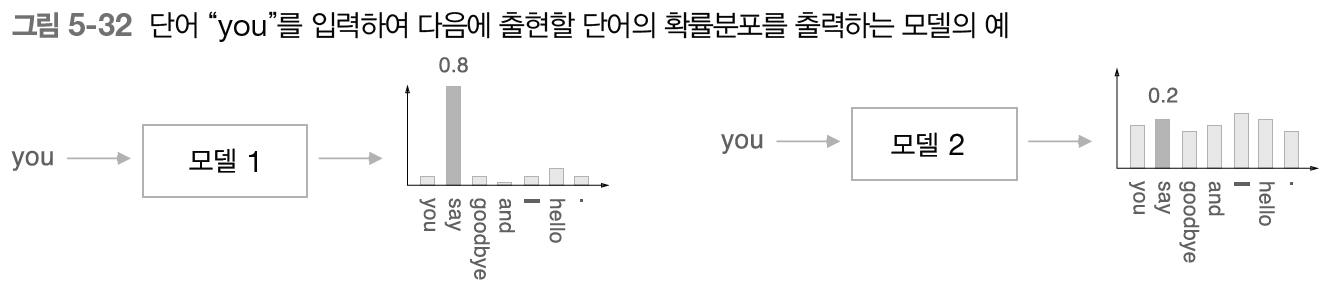

In [32]:
Image.open(os.path.join(img_path, 'fig 5-32.png'))

한편 [그림 5-32]의 오른쪽 모델('모델 2')은 정답인 "say"의 확률이 0.2라고 예측했다.Image

분명 나쁜 예측이라고 할 수 있다. 이때의 퍼플렉서티는 $\tfrac{1}{0.2} = 5$ 이다.

지금까지의 이야기를 정리해보면, 퍼플렉서티는 작을수록 좋다는 것을 알 수 있다.

그렇다면 1.25나 5.0 이라는 값은 직관적으로 어떻게 해석할 수 있을까?

이 값은 '$\text{분기수}^{\text{number of branches}}$' 로 해석할 수 있다.

분기 수란 다음에 취할 수 있는 선택사항의 수(구체적으로 말하면, 다음에 출현할 수 있는 단어의 후보 수)를 말한다.

앞의 예에서, 좋은 모델이 예측한 '분기 수'가 1.25라는 것은 다음에 출현할 수 있는 단어의 후보를 1개 정도로 좁혔다는 뜻이 된다.

반면 나쁜 모델에서는 후보가 아직 5개나 된다는 의미이다.

$\textbf{NOTE}$

앞의 예처럼 퍼플렉서티로 모델의 예측 성능을 평가할 수 있다. 좋은 모델은 정답 단어를 높은 확률로 예측할 수 있다. 따라서 퍼플렉서티 값이 작다(최솟값은 1.0). 한편, 나쁜 모델은 정답 단어를 낮은 확률로 예측하므로 퍼플렉서티 값이 크다.

지금까지는 입력 데이터가 하나일 때의 퍼플렉서티를 이야기했다. 그렇다면 입력 데이터가 여러 개일 때는 어떻게 될까?

\begin{equation*}
    L = -\cfrac{1}{N}\displaystyle\sum_{n=1}^{N}\displaystyle\sum_{k=1}^{K} t_{nk} \log y_{nk}
    \tag{5.9}
\end{equation*}

\begin{equation*}
    \text{Perplexity} = e^{L}
    \tag{5.10}
\end{equation*}

$N$ 은 데이터의 총개수이다. $t_n$ 은 원핫 벡터로 나타낸 정답 레이블이며, $t_{nk}$ 는 $n$ 개째 데이터의 $k$ 번째 값을 의미한다.

그리고 $y_{nk}$ 는 확률분포를 나타낸다(신경망에서는 Softmax의 출력).

앞의 식 (5.9)는 다소 복잡해보이나, 데이터가 하나일 때 설명한 '확률의 역수', '분기 수', '선택사항의 수'같은 개념이 그대로 적용된다.

즉, 퍼플렉서티가 작아질수록 분기 수가 줄어 좋은 모델이 된다.

$\textbf{NOTE}$

정보이론 분야에서는 퍼플렉서티를 '기하평균 분기 수'라고도 한다. 이는 데이터가 1개일 때 설명한 '분기 수'를 데이터가 $N$ 개인 경우에서 평균한 것이라고 해석할 수 있다.

### 5.5.3 RNNLM의 학습코드

PTB 데이터셋을 이용해 RNNLM 학습을 수행해본다. 단, 이번에 구현할 RNNLM은 PTB 데이터셋(훈련 데이터) 전부를 대상으로 학습하면 전혀 좋은 결과를 낼 수 없기 때문에,

처음 1,000개 단어만 이용한다. 이 문제는 다음 장에서 개선하며, 학습을 수행할 코드는 chapter05/train_custom_loop.py 를 참조한다.

기본적으로 지금까지 본 신경망 학습과 거의 같다. 다만, 큰 관점에서 두 가지가 지금까지의 학습 코드와 다르다.

바로 '데이터 제공 방법'과 '퍼플렉서티 계산'부분이다.

우선 '데이터 제공 방법'의 경우, 여기서 우리는 Truncated BPTT 방식으로 학습을 수행한다.

따라서 데이터는 순차적으로 주고 각각의 미니배치에서 데이터를 읽는 시작 위치를 조정해야 한다.

```python
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]
```

에서 각 미니배치가 데이터를 읽기 시작하는 위치를 계산해서 `offsets`에 저장한다.

다시 말해 이 `offsets`의 각 원소에 데이터를 읽는 시작 위치(오프셋)가 담기게 된다.

```python
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
```

에서는 데이터를 순차적으로 읽는다. 먼저 '그릇'인 `batch_x`와 `batch_t`를 준비한다.

그런 다음 변수 `time_idx`를 1씩(순차적으로) 늘리면서, 말뭉치에서 `time_idx`위치의 데이터를 얻는다.

여기서 앞서 계산한 `offsets`를 이용하여 각 미니배치에 오프셋을 추가한다.

또한, 말뭉치를 읽는 위치가 말뭉치 크기를 넘어설 경우 말뭉치의 처음으로 돌아와야 하는데, 이를 위해 말뭉치의 크기로 나눈 나머지를 인덱스로 사용한다.

마지막으로 퍼플렉서티는 다음 코드로 계산한다.

```python
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0
```

여기에서는 에폭마다의 퍼플렉서티를 구하기 위해 에폭마다 손실의 평균을 구하고, 그 값을 사용해서 퍼플렉서티를 계산한다.

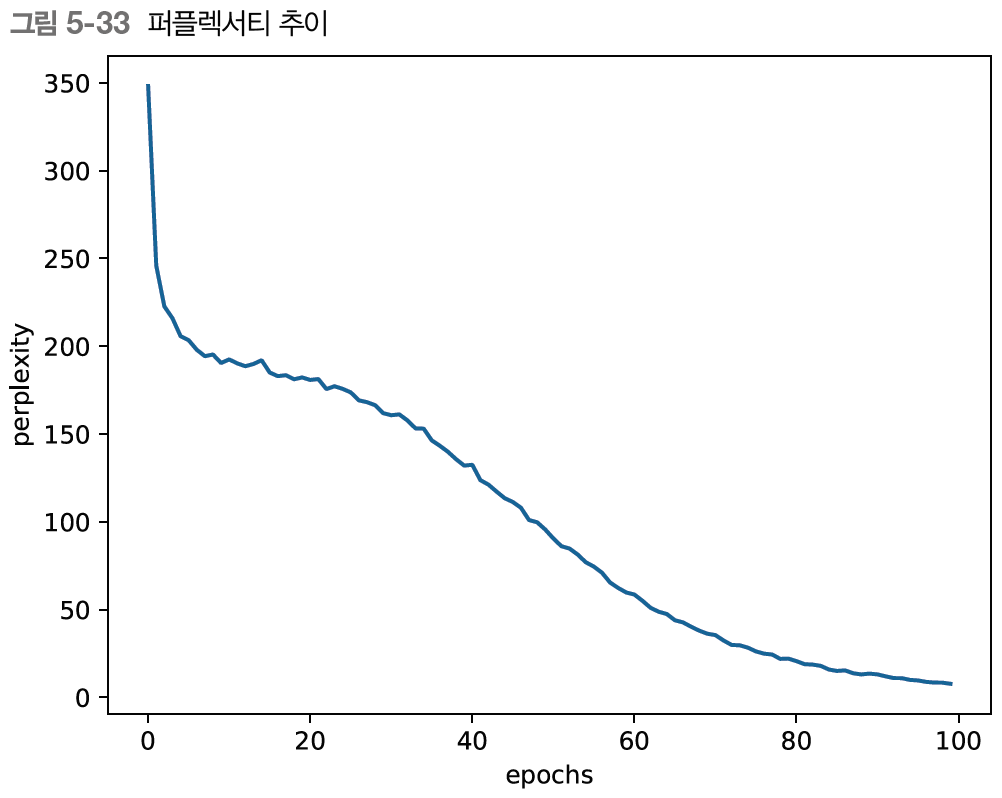

In [33]:
Image.open(os.path.join(img_path, 'fig 5-33.png'))

[그림 5-33]을 보면 학습을 진행할수록 퍼플렉서티가 순조롭게 낮아짐을 알 수 있다. 처음에는 300을 넘기던 값이 마지막에는 (최솟값인) 1에 근접했다.

다만, 이번에는 크기가 작은 말뭉치로 실험한 것이며 현재의 모델로는 큰 말뭉치에는 전혀 대응할 수 없다.

현재 RNNLM의 이런 문제는 다음 장에서 개선한다.

### 5.5.4 RNNLM의 Trainer 클래스

이 책에서는 RNNLM 학습을 수행해주는 RnnlmTrainer 클래스를 제공한다.

이 클래스는 방금 수행한 RNNLM 학습을 클래스 안으로 숨겨준다. 그래서 앞 절의 학습 코드를 RnnlmTrainer 클래스를 사용해 다시 쓰면 다음과 같다.

```python
from common.trainer import RnnlmTrainer
from dataset import ptb
from simple_rnnlm import SimpleRnnlm

...

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
```

이와 같이, 먼저 RnnlmTrainer 클래스에 `model`과 `optimizer`를 주어 초기화한다.

그런 다음 `fit()`메서드를 호출해서 학습을 수행한다. 이때 그 내부에서는 앞 절에서 수행한 일련의 작업이 진행되는데,

그 내용은 다음과 같다.

1. 미니배치를 '순차적'으로 만들어
2. 모델의 순전파와 역전파를 호출하고
3. 옵티마이저로 가중치를 갱신하고
4. 퍼플렉서티를 구한다.

$\textbf{NOTE}$

RnnlmTrainer 클래스는 '1.4.4 Trainer 클래스'절에서 설명한 Trainer 클래스와 똑같은 API를 제공한다. 신경망의 일반적인 학습은 Trainer 클래스를 사용하고, RNNLM 학습에는 RnnlmTrainer 클래스를 사용하면 된다.

## 5.6 정리

$\textbf{이번 장에서 배운 내용}$
- RNN은 순환하는 경로가 있고, 이를 통해 내부에 '은닉 상태'를 기억할 수 있다.
- RNN의 순환 경로를 펼침으로써 다수의 RNN 계층이 연결된 신경망으로 해석할 수 있으며, 보통의 오차역전파법으로 학습할 수 있다.(BPTT)
- 긴 시계열 데이터를 학습할 땐느 데이터를 적당한 길이씩 모으고(이를 '블록'이라 한다), 블록 단위로  BPTT에 의한 학습을 수행한다.(Truncated BPTT)
- Truncated BPTT에서는 역전파의 연결만 끊는다.
- Truncated BPTT에서는 순전파의 연결을 유지하기 위해 데이터를 '순차적으로' 입력해야 한다.
- 언어 모델은 단어 시퀀스를 확률로 해석한다.
- RNN 계층을 이용한 조건부 언어 모델은 (이론적으로는) 그때까지 등장한 모든 단어의 정보를 기억할 수 있다.